# （一）说明文档

# <center>基于用户历史行为的问题邀请CTR预测 </center>

【队伍名】 “LPL总冠军”团队 

【队员及机构】 
王鸿鹏，北京邮电大学；孙晟，北京邮电大学；贺同泽，北京邮电大学；
陈柯宏，北京邮电大学；万梓聪，北京邮电大学； 

摘要：在知识分享或问答社区中，问题数远远超过有质量的回复数。因此，如何连接知识、专家和用户，增加专家的回答意愿，成为了此类服务的中心课题。而知乎是知识分享社区的典型代表，随着知乎用户数量的增加，单靠用户手动邀请已经难以满足实际需求，需要依靠优秀的专家发现算法解决这个问题，即问题路由。本文为2019年知乎看山杯专家发现算法提供了一种解决方案，并取得了一定的成果。本文比较详细的介绍了我们团队在参与比赛过程中的思路和一些试错过程，核心思想是以用户为主要研究方向，从用户的历史行为挖掘有用信息，包括体现用户特性的一些信息和反应用户跟问题交互的信息去预测用户未来行为。具体采用了LightGBM等提升树模型跟xDeepFm等推荐系统常用的神经网络模型，最终结果同stacking融合不同模型得到。  

关键词：问题路由、用户历史行为、协同过滤、提升树、神经网络、stacking 

【正文】
## 一、赛题理解

知乎是每天有数以十万计的新问题以及 UGC 内容产生的网站。如何高效的将这些用户新提出的问题邀请其他用户进行解答，以及挖掘用户有能力且感兴趣的问题进行邀请下发，优化邀请回答的准确率，提高问题解答率以及回答生产数，成为知乎最重要的课题之一，在知乎内部他们称这一过程为问题路由，本次比赛旨在从选手中征集高效精准的推荐算法，挖掘有能力且感兴趣的用户进行问题地精准推荐。这是一个典型的ctr预估问题，常见的推荐系统模型都可以应用到本次比赛中去，比较常见的有LightGBM、XGBoost、GBDT等模型，还有近两年比较流行的深度模型，如deepfm、xdeep等。  

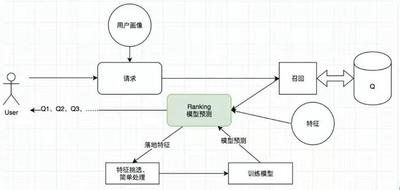

官方在邀请记录文件中提供了过去一个月来用户被邀请的记录，每条邀请是一条样本，并且标注了用户是否接受了本次邀请作为样本的标签，接受为正反之为负样本，邀请记录中还包含有邀请的时间戳。通过用户历史的邀请记录去预测未来一周用户是否会接受邀请，官方给出的训练集以及测试集实际上是经过知乎内部的召回跟排序模块之后实际推送给用户的结果，所以这些邀请实际上本身就是知乎内部模型选择后的结果，包括测试集也是，我们理解的是参赛者拿到的训练跟预测数据分布本身就是有偏的，更加偏向于用户的喜好。所以本次比赛中围绕训练集样本本身去构造特征就会有很好的效果，比如用户、问题的样本数等。

比赛数据：问题信息，用户画像，用户回答记录，用户接受邀请的记录，话题、切词、单字的64维embedding等

比赛特征：用户信息文件中包含了所有用户的相关特征信息，不过大多都是脱敏后的信息，只有性别、盐值等特征给了具体的含义；问题信息包括问题的标题、描述以及问题绑定的话题以及问题创建时间；用户回答记录中包含地信息比较丰富，不但给出了用户回答的内容，还给出了用户回答的上下文信息，包括回答时间、回答的点赞数、赞同数、反对数等。

评估指标：使用 AUC 对参赛队伍提交的数据与真实的数据进行衡量评估，  

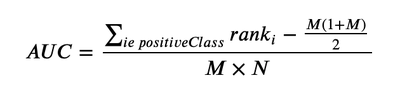
 
AUC计算方式如上式所示，M为正样本数，N为负样本数，ranki为第i个正样本所在的位置。

## 二、探索性数据分析（EDA）
### 1）数据清洗

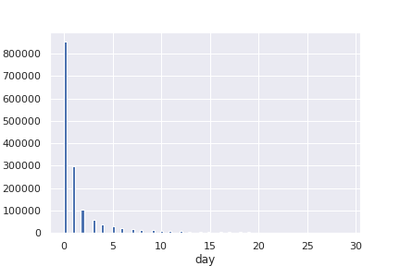
<center>Fig.2 问题邀请和回答的间隔时间</center> 

训练集起始日期是3838，结尾日期是3867，共9489162条样本，正负样本比例大概为为1：4.6，其中有2k多条样本的问题id用户id是完全相同的，这部分数据是脏数据要清洗掉。因为问题邀请的特殊性，需要有用户回答的过程，所以正样本指的是回答时间跟邀请时间间隔不超过7天的样本，而训练集中的回答间隔时间分布如下图，所以我们去除了间隔时间>10天的正样本。

### 2）周期性

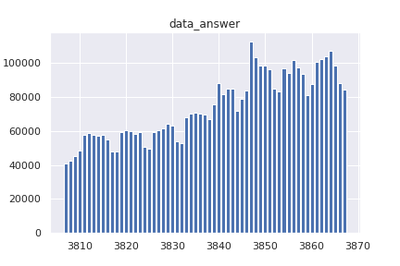
<center>Fig.3 每天的回答数量</center>

用户历史回答记录每天的回答数目呈现较强的周期性，考虑做一下周期特征，如7天前的统计特征等

### 3）样本分布

a.
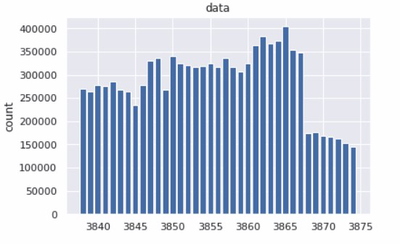    
<center>Fig.4 每天的邀请数量 </center> 
邀请本身就蕴含着很多信息，当一个问题邀请某一个用户时本身就说明该用户很可能对这个问题是感兴趣的，所以我们构造了许多邀请计数特征，并在线下取得了很好的效果，但线上的提升却是有限，从上图可以看出邀请数量的分布在训练集中是基本稳定的，但因为官方只给出了一半的验证集，所以计数特征对验证集来说是严重有偏的，这也是初赛很多参赛选手的线下线上分数差距大的一个重要原因。我们在初赛时给每一个计数赋予了一个关于当天样本总数跟当天出现的id数的权重后再加和从而使得线上线下能够相对稳定。


b.  
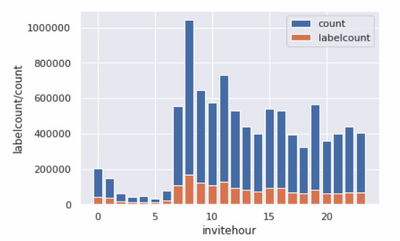 
<center>Fig.5  24小时样本数和正样本数 </center> 

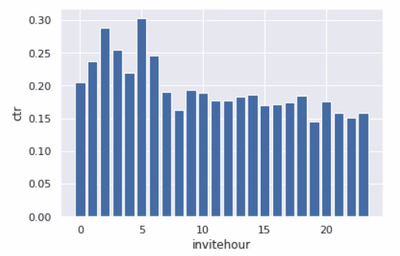
<center>Fig.6  24小时ctr </center>                
邀请时跟邀请数以及ctr的关系，不同的邀请时间的ctr分布有很大差别                

c.
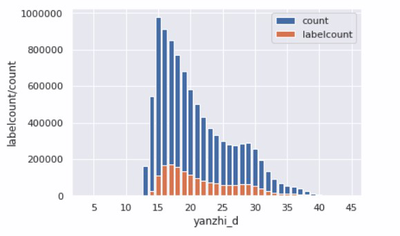 
<center>Fig.7  盐值分段对应样本数和正样本数</center> 

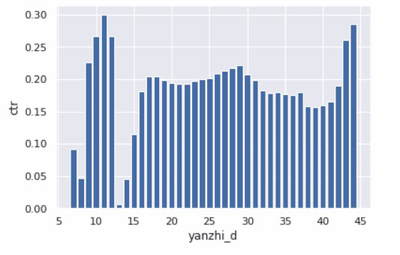 
<center>Fig.8 盐值分段对应ctr</center>
盐值跟邀请数以及ctr的关系，可以对盐值进行分箱后作为类别特征处理，常见的分箱方式有等频、等间距、卡方分箱等。


d.
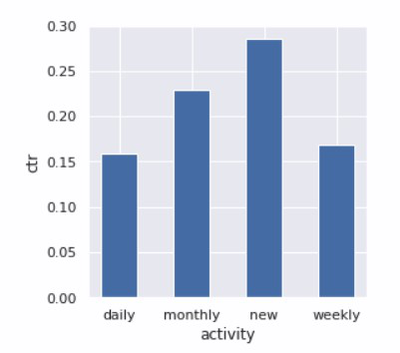
<center>Fig.9 用户访问频率</center>
对于ctr预估，用户历史行为是判断用户是否会产生行为的重要依据，而用户近期活跃度是描述用户历史表现的一个重要方面；用户信息文件给出了用户的访问频率字段，从4个层次描述了用户的近期活跃程度，如图所示，不同用户访问频率对用户是否接受问题邀请具有很大的差异。通过用户有被邀请记录的天数的分布进行分析，近似得到不同访问频率的差异


## 三、特征工程

### 1、基础特征
用户类别特征、邀请时间（星期几、小时）、问题创建时间（天、星期几、小时）等，删除了用户关键词、注册平台等没有意义的特征。

### 2、话题特征
话题特征分为用户关注话题、用户感兴趣话题以及问题绑定话题。这些其实都可以看作是问题及用户的多标签特征（tags），如何处理多标签特征，如何最大程度的保留关键信息的同时又能将标签转化为可以输入模型的特征对于推荐类问题是很重要的。我们尝试了三种方法，首先将多标签特征做countvectorizer展开成高维稀疏01矩阵（类似于one-hot），然后尝试了使用lgb模型训练根据模型重要性选择topk个标签，这种方式的结果并不理想，因为话题种数过多，所以将近一半的话题重要性为0。另外还尝试了对展开的稀疏矩阵进行PCA降维的方式，但考虑到到官方给出了话题的64维embedding向量，所以最终采用了对64维embedding降维到22维以进一步减少噪声减小特征维度后再拼接到数据上的方式。

### 3、单一侧（用户侧/问题侧）统计特征
我们采用了一些常见的统计特征，主要包括计数特征、目标编码特征（正样本数、点击率ctr等）。

ctr比赛中大多数特征都是类别特征，为了达到对不同用户个性化推荐的目的，如何精准的定位用户的喜好尤为重要，而定义用户以及问题主要靠的是不同粒度的类别特征。对于id这种类别特征，如果采用one-hot的方式，得到的是一个维数上万甚至数十数百万的稀疏矩阵，为了精准的刻画这种特征，转换为模型可以理解的形式，最常见的做法就是构造计数以及目标编码，因为本次比赛存在时间的维度，所以构造这类特征时特别是目标编码特征时要注意通过历史数据构造避免数据穿越。

如前所述，因为邀请本身就包含了丰富的含义，所以我们针对邀请数构造了多组特征，包括全局计数、过去n天计数、前三天计数等特征、当天的邀请数等统计特征，分别从近期以及全局上刻画了用户和问题的邀请信息。并考虑到测试集是有缺失的，赋予了关于数量的权重，保证线上线下相一致。

### 4、交叉特征的统计特征
通过对类别特征的交叉可以得到粒度更加细的类别特征，可以实现对用户和问题的更精确的刻画，先交叉后统计。同样的构造交叉特征的统计信息，包括计数特征、正样本数、点击率等。

### 5、问题聚类
本次比赛中用户侧类别特征较多，而问题侧类别特征较少，而测试集中新用户比例较小，而新问题比例较大，所以围绕用户的历史行为构造特征至关重要。为了提取问题类别特征跟用户交叉，我们先将问题的多个话题通过取embedding平均得到问题的embedding，然后据此对问题进行聚类，得到300个类，相当于得到了问题的单标签类别特征，然后用聚类得到的类别特征跟用户侧特征做交叉。

### 6、单一侧统计特征关于id类特征的分组统计特征
将问题id和用户id的统计特征关于用户id和问题id分组（groupby）后取均值，本质上仍然是一种交叉，相当于先统计后交叉。

### 7、文本信息处理
对于文本特征，我们主要用到了问题的title以及问题的描述，将标题跟描述的切词拼在一起之后采用TFIDF算法得到每个词的重要性，然后保留topk个作为问题的多标签特征使用。

### 8、多标签类别特征（主题、问题的内容切词序列等）的统计特征
对于topic这种多标签特征计数，对问题绑定的每一个topic都进行计数或者求ctr，并按照计算结果排序，选择结果最大的topk个作为k个统计特征，这样处理的目的仍然是进一步过滤不重要的topic。
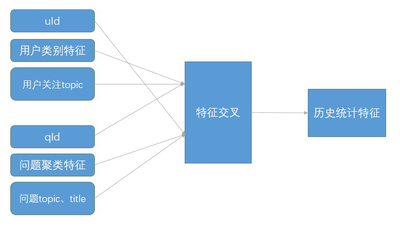
<center>Fig.10 交叉统计特征</center>

### 9、相似性特征
主要是利用主题跟TFIDF过滤后的问题切词计算相似度，包括两部分，下面以话题为例进行说明：  
1）第一部分是计算当前问题的绑定话题跟用户关注话题之间的相似性，利用话题的64维embedding求cos相似度，分别将问题绑定的话题和用户关注话题的embedding加和求平均后计算两个向量的cos相似度。  
2）第二部分是根据用户的历史行为计算用户历史行为跟当前问题的关系，包括计算当前问题与历史回答问题的cos相似度，以及与历史未接收邀请问题的cos相似度。我们尝试了多种计算方法，最开始采用将历史问题的绑定话题embedding加和取平均的方式，效果并不理想，通过实验发现，用户的历史回答问题越多，用户的历史信息越稳健，整体表现越好，所以我们将cos相似度进行了修改，对结果赋了一个关于历史回答问题数量的权重，得到了较好的改进。最终，我们采用了基于物品的协同过滤（itemCF）的思想，我们计算当前问题跟用户历史回答的每一个问题的相似度，考虑到用户回答一个问题可能仅仅是因为用户对该问题的部分话题感兴趣，所以计算问题相似度时不再采用对话题embedding加和平均求相似度的方式，而是先对两个问题绑定的话题分别两两求cos相似度后取相似度较大的topk再取平均的方式，这种方式可以更好地刻画不同问题的单个方面的相似程度。ItemCF基于如下公式计算用户对一个物问题的兴趣（即当前问题跟历史问题的相似度）：

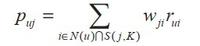  

这里N(u)是用户喜欢的物品的集合， S(j,K)是和物品j最相似的K个物品的集合，wji是物品j和i
的相似度，rui是用户u对物品i的兴趣，这里对所有回答过的问题r都取为1。我们只保留与当前问题相似度较高的历史问题，并对这些保留下来的问题与当前问题相似度加和而非取平均，以保留回答数量信息。

### 10、其它特征
1）为了更好地刻画用户的近期活跃程度，我们针对邀请与回答分别刻画了用户的活跃度特征、以及距离上一次邀请的间隔时长等；类似的，我们还构造了问题的近期活跃度特征，以及上次邀请间隔时长，以及问题生存时长等；我们还尝试构建了最近一次用户回答/问题被回答的时间间隔，在线下具有不错的表现，但线上因为测试集时间跨度过长（7天），导致该特征分布线上线下分布差异性很大，最终没有采用；  
2）用户历史回答反馈信息，对用户历史回答记录的点赞数、取赞数、反对数、字数等字段进行聚合，聚合方式采用了mean、sum、max等，这些特征包含了用户历史行为的一些反馈信息。

## 四、nn部分
### 1、模型结构
本次比赛中使用网络结构主要是基于xDeepFM网络结构的改进。利用CIN网络结构处理类别特征的交叉，利用MLP处理数值型数据，利用deepWalk得到社交网络数据，最终将三者进行拼接输入到MLP中，得到最终效果。同时，训练中使用Adam+Lookahead的优化器。模型具体结构如下图。

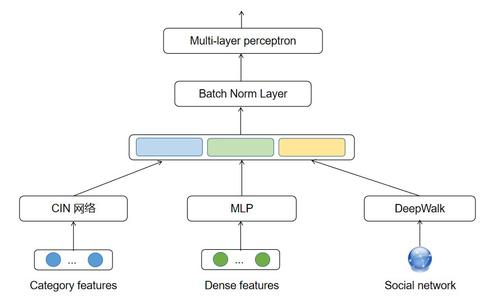
<center>Fig.11 模型结构</center>

### 2、关键技巧
本方案的关键技巧主要包括：
1）Deepwalk信息作为输入。考虑到业务背景，知乎平台对用户发出邀请一定是问题和用户之间有着某种联系，因此基于邀请进行deepwalk，并将其作为网络的一部分输入。
2）基于用户历史信息的用户感兴趣的主题、关键字特征。通过提供的answer文件，获取当前用户过去n天的历史回答信息，根据主题在不同问题上的出现频率，为不同主题设置相应的权重，出现频率越高，权重越大。
3）基于用户未接受邀请信息的用户讨厌关键字、主题特征。这一特征和前一个特征类似，主要从用户未接受邀请的问题中提取关键字、主题，同样分配不同的权重，出现次数越高权重越大。
4）将带有权重的多值特征送入到CIN网络中。对多值特征进行embedding，根据相应的权重进行加和，并除以权重之和，得到多值特征向量送入到网络
5）采用Adam+Lookahead优化器。
### 3、网络结构探索
1）、尝试加入Memory结构：
利用memory结构捕捉用户的历史信息。对基于基础信息的预测使用此结构有提高，但同时加入人工提取的历史信息，结果反而变差。怀疑是网络捕捉的历史信息中引入噪声，尝试对memory网络进行改造，采用类似RNN结构，利用sigmoid函数有选择的将捕捉到的历史信息加入网络其中，效果比之前有所提升。但是，添加更多的人工历史特征后，结果依然变差。因此在历史信息的获取中，我们采用人工构造特征，没有使用这个结构。同时实验发现，针对小数据集时，网络不能很好的拟合人工特征进行预测，单纯加入memory效果更好。  
2）、尝试采用TextCNN捕捉用户和问题间的主题关系
在最开始的时候，使用TextCNN捕捉用户主题和问题主题间的关系，得到了不错的结构。后来尝试使用CIN结构进行特征交叉后，加上TextCNN这一结构到时结果变差。怀疑是因为CIN能够很好的捕捉特征间的交互，加入的TextCNN结构反而引入噪声，因此最后的预测中没有使用TextCNN结构  
3）、尝试利用单独CIN进行word，topic的交叉
因为word，topic的维度相同，根据官方描述，处于相同空间，因此尝试利用单独的CIN结构捕捉word，topic，实验显示相比所有类别特征送入CIN中效果更差。猜测word、topic和其他特征的交叉对预测结果有帮助，比如：男性+游戏的交叉。

## 五、模型融合

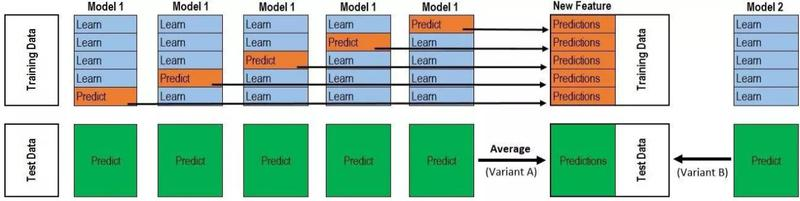

最终结果采用LightGBM、CatBoost、XGBoost、DNN四个模型融合的方式，其中LightGBM、CatBoost、XGBoost主要采用基础稠密特征，这部分内容在特征工程部分进行了简单的说明，DNN在使用了基础特征、稠密特征以及embedding特征，不同的模型经过特征选择后对结果相似性差异较大的模型方案采用stacking的方式融合得到最终结果。

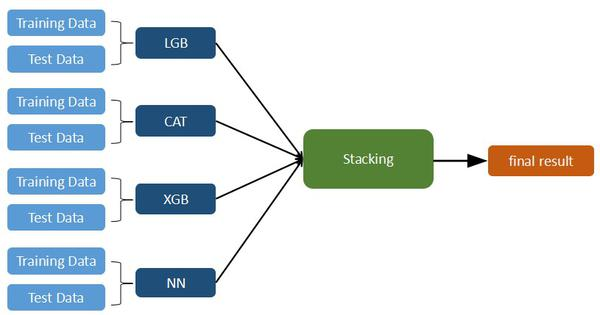

*优化器已上传到https://github.com/VoldeMortzzz/2019Baai-zhihu-Cup-findexp-4th 有需要的可以自取

# （二）代码

In [6]:
import numpy as np
import pandas as pd
import warnings
import random
import os
import gc
import math
from multiprocessing import Pool,cpu_count
from sklearn.preprocessing import Normalizer,LabelEncoder,OneHotEncoder,MinMaxScaler
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from scipy import sparse
import matplotlib.pyplot as plt
from gensim.models import word2vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath as dpath, get_tmpfile
import torch 
import codecs
import xgboost as xgb
import lightgbm as lgb
import catboost as catb
import pickle
import time
import datetime
import math
import scipy.special as special
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from optimizer import Lookahead
from optimizer import RAdam
import torch.utils.data as Data
import codecs
import sys
import jieba.posseg
import jieba.analyse
import re
import warnings
warnings.filterwarnings('ignore')
datapath = '.....'

t0_train = 3838
t1_train = 3867
t0_eval = 3868
t1_eval = 3874
t0_a = 3807
t1_a = 3867
evalday = 7

In [1]:
def memoryOptimization(data,floattype):
    subdata = data.select_dtypes(include = 'int')
    for col in subdata.columns:
        m = subdata[col].max()
        n = subdata[col].min()
        if m < np.power(2,31)-1 and n >=  -np.power(2,31):
            if m < np.power(2,15)-1 and n >=  -np.power(2,15):
                if m < np.power(2,7)-1 and n >=  -np.power(2,7):
                    subdata[col] = subdata[col].astype(np.int8)
                else:
                    subdata[col] = subdata[col].astype(np.int16)
            else:
                subdata[col] = subdata[col].astype(np.int32)
    data[subdata.columns] = subdata
    subdata = data.select_dtypes(include = 'float')
    data[subdata.columns] = data[subdata.columns].astype(floattype)
#     subdata = data.select_dtypes(include = 'object')
#     data[subdata.columns] = data[subdata.columns].astype('category')
    gc.collect()
    return data

# def down_sample(df,df_feat,rate):#对目标特征下采样，通过给定随机数种子保证每个特征组抽样的负样本是同样的
#     df_majority = df_feat[df['label']==0]
#     df_minority = df_feat[df['label']==1]
#     positive_num = df_minority.shape[0]
#     df_majority_downsampled = resample(df_majority,
#                                      replace=False,  # sample without replacement
#                                      n_samples=positive_num*rate,  # to match minority class
#                                      random_state=7)  # reproducible results
#     df_downsampled = pd.concat([df_majority_downsampled, df_minority],axis = 0,ignore_index = True)
#     del df_majority, df_minority, df_majority_downsampled
#     return df_downsampled

def lgb_train_pre1(train_x,train_y,test_x,categoryfeas,dropfeas,one,save_model):    
    train_x = train_x.drop(dropfeas+['inviteday','inviteallhour'],axis = 1)
    test_x = test_x.drop(dropfeas+['inviteday','inviteallhour'],axis = 1)
    pickle.dump(list(train_x.columns), open(datapath+'data/lgb_fea.pkl', 'wb'))
    params_lgbc ={
        'boosting_type': 'gbdt',
        'objective': 'binary',  
        'num_leaves': 41, 
        'learning_rate': 0.1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'min_sum_hessian_in_leaf': 10,
        'num_threads': cpu_count() - 1,
        'seed': 7, 
        'n_estimators':50000,
        'max_depth': 6,
        'subsample':0.9,
        'subsample_freq':2,
        'reg_alpha':0, 
        'reg_lambda':2
        # 'device': 'gpu',
    }
    
    pre_train = pd.Series(np.zeros(len(train_y)))
    pre_test = []
    kf = StratifiedKFold(n_splits = 5,shuffle = True,random_state = 2019)
    fold = 1
    for train_index,eval_index in kf.split(train_x,train_y):
        dtrain_x = train_x.loc[train_index,:]
        deval_x = train_x.loc[eval_index,:]
        dtrain_y = train_y[train_index]
        deval_y = train_y[eval_index]
        if flag_weight:
            sample_weight = ((dtrain_x['inviteday']-3500)/(dtrain_x['inviteday']-3500).mean()).values
        else:
            sample_weight = None
        lgbc = lgb.LGBMClassifier(random_state = 2020,**params_lgbc) # np.random.randint(1,3000)
        lgbc.fit(dtrain_x,dtrain_y,eval_set = [(deval_x,deval_y)],eval_names = ['eval'],eval_metric = 'auc',
                 early_stopping_rounds = 50,sample_weight = sample_weight,verbose = 100,categorical_feature = categoryfeas)
        pre_train[eval_index] = lgbc.predict_proba(deval_x,num_iteration = lgbc.best_iteration_)[:,1]
        pre_test.append(list(lgbc.predict_proba(test_x,num_iteration = lgbc.best_iteration_)[:,1]))
        if save_model:
            joblib.dump(lgbc, open(datapath+'data/lgb_'+str(params_lgbc['learning_rate'])+'_'+str(fold)+'.pkl', 'wb'))
        fold += 1
        if one:
            break
    pre_test = np.array(pre_test)
    pre_test = np.mean(pre_test,axis = 0)
    
    score = roc_auc_score(train_y,pre_train)
    feas = train_x.columns
    imps = lgbc.feature_importances_
    fea_imp = pd.DataFrame(pd.Series(feas),columns = ['feas'])
    fea_imp['imp'] = imps
    fea_imp = fea_imp.sort_values(by = 'imp',ascending = False)
    del dtrain_x
    del deval_x
    del dtrain_y
    del deval_y
    gc.collect()
    return pre_test,pre_train,score,fea_imp,lgbc.best_iteration_
def xgb_train_pre1(train_x,train_y,test_x,dropfeas,one,save_model):
    train_x = train_x.drop(dropfeas+['inviteday','inviteallhour'],axis = 1)
    test_x = test_x.drop(dropfeas+['inviteday','inviteallhour'],axis = 1)
    pickle.dump(list(train_x.columns), open(datapath+'data/xgb_fea.pkl', 'wb'))
    params_lgbc ={        
        'booster':'gbtree',
        'learning_rate':0.1,
        'n_estimators':50000,
        'max_depth':6,
        'min_child_weight':3,
        'gamma':0.1,
        'subsample':0.9,
        'colsample_bytree':0.8,
        'reg_alpha':0, 
        'reg_lambda':2,
        'objective':'binary:logistic',
        'nthread':cpu_count() - 1,
        'scale_pos_weight':1,
        'seed':7,
#         'tree_method':'gpu_hist'
    }
    
    pre_train = pd.Series(np.zeros(len(train_y)))
    pre_test = []
    kf = StratifiedKFold(n_splits = 5,shuffle = True,random_state = 2019)
    fold = 1
    for train_index,eval_index in kf.split(train_x,train_y):
        dtrain_x = train_x.loc[train_index,:]
        deval_x = train_x.loc[eval_index,:]
        dtrain_y = train_y[train_index]
        deval_y = train_y[eval_index]
        if flag_weight:
            sample_weight = ((dtrain_x['inviteday']-3500)/(dtrain_x['inviteday']-3500).mean()).values
        else:
            sample_weight = None
        xgbc = xgb.XGBClassifier(random_state = 2019,**params_lgbc)
        xgbc.fit(dtrain_x,dtrain_y,eval_set = [(deval_x,deval_y)],eval_metric = 'auc',
                 early_stopping_rounds = 50,sample_weight = sample_weight,verbose = 100)
        pre_train[eval_index] = xgbc.predict_proba(deval_x, ntree_limit=xgbc.best_ntree_limit)[:,1]
        pre_test.append(list(xgbc.predict_proba(test_x, ntree_limit=xgbc.best_ntree_limit)[:,1]))
        if save_model:
            joblib.dump(xgbc, open(datapath+'data/xgb_'+str(params_lgbc['learning_rate'])+'_'+str(fold)+'.pkl', 'wb'))
        fold += 1
        if one:
            break
    pre_test = np.array(pre_test)
    pre_test = np.mean(pre_test,axis = 0)
    
    score = roc_auc_score(train_y,pre_train)
    feas = train_x.columns
    imps = xgbc.feature_importances_
    fea_imp = pd.DataFrame(pd.Series(feas),columns = ['feas'])
    fea_imp['imp'] = imps
    fea_imp = fea_imp.sort_values(by = 'imp',ascending = False)
    del dtrain_x
    del deval_x
    del dtrain_y
    del deval_y
    gc.collect()
    return pre_test,pre_train,score,fea_imp,xgbc.best_iteration
def cat_train_pre1(train_x,train_y,test_x,categoryfeas,dropfeas,one,save_model):
    train_x = train_x.drop(dropfeas+['inviteday','inviteallhour'],axis = 1)
    test_x = test_x.drop(dropfeas+['inviteday','inviteallhour'],axis = 1)
    pickle.dump(list(train_x.columns), open(datapath+'data/cat_fea.pkl', 'wb'))
    params_lgbc ={        
        'learning_rate':0.1,
        'n_estimators':50000,
        'max_depth':6,
#         'subsample':0.9,
        'l2_leaf_reg':2,
        'objective':'Logloss',
        'scale_pos_weight':1,
        'eval_metric':'AUC',
        'colsample_bylevel':0.8
    }
    
    pre_train = pd.Series(np.zeros(len(train_y)))
    pre_test = []
    kf = StratifiedKFold(n_splits = 5,shuffle = True,random_state = 2019)
    fold = 1
    for train_index,eval_index in kf.split(train_x,train_y):
        dtrain_x = train_x.loc[train_index,:]
        deval_x = train_x.loc[eval_index,:]
        dtrain_y = train_y[train_index]
        deval_y = train_y[eval_index]
        catbc = catb.CatBoostClassifier(random_state = 2019,**params_lgbc)
        catbc.fit(dtrain_x,dtrain_y,eval_set = [(deval_x,deval_y)],cat_features = categoryfeas, # eval_metric = 'auc',
                 early_stopping_rounds = 50,sample_weight = sample_weight,verbose = 100)
        pre_train[eval_index] = catbc.predict_proba(deval_x)[:,1]
        pre_test.append(list(catbc.predict_proba(test_x)[:,1]))
        if save_model:
            joblib.dump(catbc, open(datapath+'data/cat_'+str(params_lgbc['learning_rate'])+'_'+str(fold)+'.pkl', 'wb'))
        fold += 1
        if one:
            break
    pre_test = np.array(pre_test)
    pre_test = np.mean(pre_test,axis = 0)
    
    score = roc_auc_score(train_y,pre_train)
    feas = train_x.columns
    imps = catbc.get_feature_importance()
    fea_imp = pd.DataFrame(pd.Series(feas),columns = ['feas'])
    fea_imp['imp'] = imps
    fea_imp = fea_imp.sort_values(by = 'imp',ascending = False)
    del dtrain_x
    del deval_x
    del dtrain_y
    del deval_y
    gc.collect()
    return pre_test,pre_train,score,fea_imp,catbc.get_best_iteration()

def parallelize_dataframe(df,func):
    df_split = np.array_split(df,20)#cpu_count()
    pool = Pool(20)#cpu_count()
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def mostliketheme(x):
    if x == '-1':
        return '-1'
    for theme in iter(x.strip().split(',')):
        theme = theme.strip().split(':')
        try:
            if float(theme[1])>biggestlike:
                biggestlike = theme[1]
                mostliketheme = theme[0]
        except:
            biggestlike = theme[1]
            mostliketheme = theme[0]
    return mostliketheme

def getweekday(data):
    return data%7

# .数据处理

## 一、预处理

### 词向量

处理词向量文件

In [ ]:
data_word = pd.read_csv(datapath+'data/word_vectors_64d.txt',sep = ' ',header = None,
                        names = ['word_'+str(i) for i in range(64)])

d = data_word['word_0'].apply(lambda x:x.split('\t'))
data_word['wordId'] = d.apply(lambda x:x[0])
data_word['word_0'] = d.apply(lambda x:x[1]).astype(np.float32)
data_word = memoryOptimization(data_word,np.float32)

data_word.to_csv(datapath+'data/word_vector.csv',header = True,index = False)
del data_word
del d
gc.collect()

### 单字向量

处理单字向量文件

In [ ]:
data_letter = pd.read_csv(datapath+'data/single_word_vectors_64d.txt',sep = ' ',header = None,
                        names = ['letter_'+str(i) for i in range(64)])

d = data_letter['letter_0'].apply(lambda x:x.split('\t'))
data_letter['letterId'] = d.apply(lambda x:x[0])
data_letter['letter_0'] = d.apply(lambda x:x[1]).astype(np.float32)
data_letter = memoryOptimization(data_letter,np.float32)

data_letter.to_csv(datapath+'data/letter_vector.csv',header = True,index = False)
del data_letter
del d
gc.collect()

### 话题向量

处理话题向量文件

In [ ]:
data_theme = pd.read_csv(datapath+'data/topic_vectors_64d.txt',sep = ' ',header = None,
                        names = ['theme_'+str(i) for i in range(64)])

d = data_theme['theme_0'].apply(lambda x:x.split('\t'))
data_theme['themeId'] = d.apply(lambda x:x[0])
data_theme['theme_0'] = d.apply(lambda x:x[1]).astype(np.float32)
data_theme = memoryOptimization(data_theme,np.float32)
data_theme.to_csv(datapath+'data/theme_vector.csv',header = True,index = False)


利用pca将64维的话题向量进行压缩为22维，以进一步去除噪声

In [ ]:
normalizer = Normalizer(copy = False)
data_pca = data_theme[['theme_'+str(i) for i in range(64)]]
data_pca = normalizer.fit_transform(data_pca)
n = int(64*0.35)
svd = TruncatedSVD(n_components = n)
data_pca = svd.fit_transform(data_pca)
data_pca= pd.DataFrame(data_pca,columns = ['theme_'+str(i) for i in range(n)])
data_pca['themeId'] = data_theme['themeId']

data_pca.to_csv(datapath+'data/theme_vector_pca.csv',header = True,index = False)
del data_theme
del data_pca
del d
gc.collect()

### 回答记录文件

处理回答记录文件，根据回答时间字段生成回答的天、时字段

In [ ]:
columns = ['answerId','qId','writerId','answertime','content_letters','content_words','good_bool','recommend_bool','yuanzhuo_bool',
           'picture_bool','vedio_bool','wordnum','likenum','cancellikenum','commentnum','collectnum','3qnum','jubaonum','unhelpnum',
           'unlikenum']
data_answer = pd.read_csv(datapath+'data/answer_info.txt',sep = '\t',header = None,names = columns)
data_answer['answerday'] = np.nan
data_answer['answerhour'] = np.nan
data_answer['answerday'] = data_answer['answertime'].apply(lambda x: int(x.split('-')[0][1:]))
data_answer['answerhour'] = data_answer['answertime'].apply(lambda x: int(x.split('-')[1][1:]))
data_answer = memoryOptimization(data_answer,np.float32)

data_answer.to_csv(datapath+'data/data_answer.csv',header = True,index = False)
del data_answer
gc.collect()

### 问题文件

处理问题信息文件，根据问题创建时间字段生成问题创建的的天、时字段  

In [ ]:
columns = ['qId','createtime','title_letters','title_words','describe_letters','describe_words','themeId']
data_question = pd.read_csv(datapath+'data/question_info.txt',sep = '\t',header = None,names = columns)

data_question['createday'] = np.nan
data_question['createhour'] = np.nan
data_question['createday'] = data_question['createtime'].apply(lambda x: int(x.split('-')[0][1:]))
data_question['createhour'] = data_question['createtime'].apply(lambda x: int(x.split('-')[0][1:]))
data_question = memoryOptimization(data_question,np.float32)

data_question.to_csv(datapath+'data/data_question.csv',header = True,index = False)

问题绑定的话题相当于问题的tag字段，直接做countvector成类似onehot的形式维度过大，所以这里采用利用给定话题64维向量pca降维压缩并聚合的方式表示问题tag，利用pca后得到的话题的22维embedding，得到问题关于话题的一个embdeding表示，具体方法是：  
1）将问题绑定的多个话题的对应22维em加和取平均  
2）如果问题绑定的话题为缺失，即‘-1’，则对应的emb为nan  
代码如下：

In [ ]:
t2v_pca = pd.read_csv(datapath+'data/theme_vector_pca.csv')
cols = list(t2v_pca.columns)
cols.remove('themeId')
cols = ['themeId']+cols
t2v_pca = t2v_pca[cols]
dic_t2v_pca = {}
for row in iter(t2v_pca.values):
    dic_t2v_pca[row[0]] = row[1:]

def get_data_themeembs(data):
    result = []
    for themes in iter(data['themeId'].values):
        if themes == '-1':
            result.append([])
            continue
        cur = np.zeros(int(64*0.35))
        themes = themes.split(',')
        for theme in iter(themes):
            cur = cur + dic_t2v_pca[theme]
        cur = cur/len(themes)
        result.append(list(cur))
    return pd.DataFrame(result,columns = ['themeId'+str(i) for i in range(int(64*0.35))])

q_theme = parallelize_dataframe(data_question,get_data_themeembs)
q_theme.to_csv(datapath+'data/question_theme.csv',header = True,index = False)

del data_question
del q_theme
del t2w_pca
gc.collect()

对问题title跟描述利用TFIDF进行过滤

In [ ]:
def gen_idf(corpus,outputfile):
    ignored = {'', ' ', '', '。', '：', '，', '）', '（', '！', '?', '”', '“'}
    id_freq = {}
    i = 0
    for doc in corpus:
        doc = set(x for x in doc if x not in ignored)
        for x in doc:
            id_freq[x] = id_freq.get(x, 0) + 1
        i += 1
    with open(outputfile, 'w', encoding='utf-8') as f:
        for key, value in id_freq.items():
            f.write(key + ' ' + str(math.log(i / value, 2)) + '\n')
            
class IDFLoader(object):
    def __init__(self, idf_path):
        self.idf_path = idf_path
        self.idf_freq = {}     # idf
        self.mean_idf = 0.0    # 均值
        self.load_idf()

    def load_idf(self):       # 从文件中载入idf
        cnt = 0
        with open(self.idf_path, 'r', encoding='utf-8') as f:
            for line in f:
                try:
                    word, freq = line.strip().split(' ')
                    cnt += 1
                except Exception as e:
                    pass
                self.idf_freq[word] = float(freq)

        print('Vocabularies loaded: %d' % cnt)
        self.mean_idf = sum(self.idf_freq.values()) / cnt
        
class TFIDF(object):
    def __init__(self, idf_path):
        self.idf_loader = IDFLoader(idf_path)
        self.idf_freq = self.idf_loader.idf_freq
        self.mean_idf = self.idf_loader.mean_idf

    def extract_sentence_keywords(self, sentence,filter_word=None,topK=None,all_tfidf = False):    # 提取关键词
        # 过滤
        #seg_list = segment(sentence)
        seg_list = [x for x in sentence if len(x)>1]
        freq = {}
        for w in seg_list:
            freq[w] = freq.get(w, 0.0) + 1.0
        total = sum(freq.values())

        for k in freq:   # 计算 TF-IDF
            freq[k] *= self.idf_freq.get(k, self.mean_idf) / total


        tags = sorted(freq, key=freq.__getitem__, reverse=True)  # 排序
        if filter_word!=None:
            tags = [x for x in tags if x not in filter_word]
        if topK!=None:
            if all_tfidf:
                return tags[:topK],freq
            else:
                return tags[:topK]
        else:
            if all_tfidf:
                return tags,freq
            else:
                return tags
            
    def extract_corpus_keywords(self, corpus, filter_word=None,topK=None,all_tfidf = False):    # 提取关键词
        # 过滤
        #seg_list = segment(sentence)
        all_tags = []
        all_freq = []
        for sentence in corpus:
            seg_list = [x for x in sentence if len(x)>1]
            freq = {}
            for w in seg_list:
                freq[w] = freq.get(w, 0.0) + 1.0
            total = sum(freq.values())

            for k in freq:   # 计算 TF-IDF
                freq[k] *= self.idf_freq.get(k, self.mean_idf) / total
            if all_tfidf:
                all_freq.append(freq)
            tags = sorted(freq, key=freq.__getitem__, reverse=True)  # 排序
            if filter_word!=None:
                tags = [x for x in tags if x not in filter_word]
            if topK!=None:
                 all_tags.append(tags[:topK])
            else:
                all_tags.append(tags)
        if all_tfidf:            
            return all_tags,all_freq
        else:
            return all_tags


question_info = pd.read_csv(datapath+'data/question_info.txt', header=None, sep='\t')
question_info.columns = ['问题id','问题创建时间','问题标题单字编码','问题标题切词编码','问题描述单字编码','问题描述切词编码','问题绑定话题']
question_info['len'] = question_info['问题标题切词编码'].apply(lambda x:len(x.split(',')))
question_info['len'].max()

def text(row):
    text = row.问题标题切词编码.split(',')
    if row.问题描述切词编码!=str(-1):
        text.extend(row.问题描述切词编码.split(','))
    return text
question_info['text'] = question_info.apply(lambda row:text(row),axis=1)
question_info['title'] =  question_info['问题标题切词编码'].apply(lambda x:x.split(','))

out_file = datapath+'data/问题标题.idf.txt'
if not os.path.exists(out_file):
    corpus = question_info.title.values.tolist()
    gen_idf(corpus,out_file)
tdidf = TFIDF(out_file)
x = question_info.title.values.tolist()
tags = tdidf.extract_corpus_keywords(x)
question_info['tfidf_title'] = tags
del x,tags
gc.collect()

out_file = datapath+'data/问题标题描述.idf.txt'
if not os.path.exists(out_file):
    corpus = question_info.text.values.tolist()
    gen_idf(corpus,out_file)
tdidf = TFIDF(out_file)
x = question_info.text.values.tolist()
tags = tdidf.extract_corpus_keywords(x)
question_info['tfidf_text'] = tags
demo_data = question_info[['问题id','len','tfidf_text','tfidf_title','问题描述切词编码']]

def get_topk(row):
    ### title
#     if row.问题标题切词编码==str(-1):
#         return
    n = round(row.len/3)
    if n==0:
        n=1
    row['title_topk'] = row.tfidf_title[:n]
    if row.问题描述切词编码==str(-1):
        row['text_topk'] = row.tfidf_text[:n]
    else:
        if row.tfidf_title[0]=='-1':
            m = min(4,round(2*len(row.tfidf_text)/3))
            row['text_topk'] = row.tfidf_text[:m]
        else:
            row['text_topk'] = row.tfidf_text[:round(2*row.len/3)]
    return row


def parallelize_dataframe(df, func):
    df_split = np.array_split(df, 16)
    pool = Pool(16)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df
def get_topk_all(df):
    df = df.apply(lambda row:get_topk(row),axis=1)
    return df

demo_data = parallelize_dataframe(demo_data, get_topk_all)
demo_data['问题标题切词编码']=question_info['问题标题切词编码']

def clean_1(ls):
    if len(ls)==1 and ls[0]=='-1':
        return ls
    ls = [x for x in ls if x!='-1']
    return ls

x = demo_data[["问题id",'title_topk','text_topk']]
x['text_topk'] = x['text_topk'].apply(lambda x:clean_1(x))
x['title_topk'] = x['title_topk'].apply(lambda s:','.join(s))
x['text_topk'] = x['text_topk'].apply(lambda s:','.join(s))
x.to_csv(datapath+'data/data_q_title_tfidf.csv')

### 用户文件

处理用户信息文件,  
drop掉keywords等没有意义的列；  
将类别特征中的‘unknown’替换为nan；  
构建用户最感兴趣的主题；

In [ ]:
columns = ['writerId','sex','keywords','publishrank','heatrank','registertype','platform','activity','bool_A','bool_B','bool_C',
          'bool_D','bool_E','category_A','category_B','category_C','category_D','category_E','yanzhi','attentionthemes','likethemes']
data_writer = pd.read_csv(datapath+'data/member_info.txt',sep = '\t',names = columns)
data_writer.drop(['keywords','publishrank', 'heatrank', 'registertype', 'platform'],axis = 1)
data_writer[data_writer.select_dtypes(include = 'object').columns] = data_writer.select_dtypes(include = 'object').applymap(lambda x: float('nan') if x == 'unknown' else x)

def mostliketheme(x):
    if x == '-1':
        return '-1'
    for theme in iter(x.strip().split(',')):
        theme = theme.strip().split(':')
        try:
            if float(theme[1])>biggestlike:
                biggestlike = theme[1]
                mostliketheme = theme[0]
        except:
            biggestlike = theme[1]
            mostliketheme = theme[0]
    return mostliketheme

data_writer['mostliketheme'] = data_writer['likethemes'].apply(mostliketheme)
data_writer = memoryOptimization(data_writer,np.float32)
data_writer.to_csv(datapath+'data/data_writer.csv',header = True,index = False)

与问题文件类似的，利用话题的22维emb分别得到用户关于用户关注话题的emb以及关于用户感兴趣的话题的emb，  
其中感兴趣话题的聚合方式是加权平均，权重是用户对该话题感兴趣程度

In [ ]:
t2v_pca = pd.read_csv(datapath+'data/theme_vector_pca.csv')
cols = list(t2v_pca.columns)
cols.remove('themeId')
cols = ['themeId']+cols
t2v_pca = t2v_pca[cols]
dic_t2v_pca = {}
for row in iter(t2v_pca.values):
    dic_t2v_pca[row[0]] = row[1:]

def get_data_themeembs(data):
    result = []
    for themes in iter(data['attentionthemes'].values):
        if themes == '-1':
            result.append([])
            continue
        cur = np.zeros(int(64*0.35))
        themes = themes.split(',')
        for theme in iter(themes):
            cur = cur + dic_t2v_pca[theme]
        cur = cur/len(themes)
        result.append(list(cur))
    return pd.DataFrame(result,columns = ['attentionthemes'+str(i) for i in range(int(64*0.35))])

writer_attentionthemes = parallelize_dataframe(data_writer,get_data_themeembs)
writer_attentionthemes.to_csv(datapath+'data/writer_attentiontheme.csv',header = True,index = False)

def get_data_themeembs_weight(data):
    def f(s,data_v,leix):
        result = np.zeros(22)
        if s == '-1':
            return result
        s = s.strip().split(',')
        for t in iter(s):
            t = t.strip().split(':')
            result = result+data_v.loc[data_v[leix+'Id'] == t[0],[leix+'_'+str(i) for i in range(22)]].values[0]*float(t[1])
        try:
            result = result/len(s)
        except:
            pass
        return result
    data_v = t2v_pca
    col = 'likethemes'
    leix = 'theme'
    return pd.DataFrame(list(data.apply(lambda x:f(x,data_v,leix))),columns = [col+str(i) for i in range(int(64*0.35))])

writer_likethemes = parallelize_dataframe(data_writer['likethemes'],get_data_themeembs_weight)
writer_likethemes.to_csv(datapath+'data/writer_liketheme.csv',header = True,index = False)

del data_writer
del writer_likethemes
del writer_attentionthemes
gc.collect()

### 训练集
处理训练集，根据邀请时间字段生成邀请的天、时字段 

In [ ]:
data_invite = pd.read_csv(datapath+'data/invite_info.txt',sep = '\t',header = None,names = ['qId','writerId','invitetime','label'])
data_invite['inviteday'] = np.nan
data_invite['invitehour'] = np.nan
data_invite['inviteday'] = data_invite.invitetime.apply(lambda x: int(x.split('-')[0][1:]))
data_invite['invitehour'] = data_invite.invitetime.apply(lambda x: int(x.split('-')[1][1:]))
data_invite = memoryOptimization(data_invite,np.float32)

根据官方的说法一个问题只会对同一个用户邀请一次，训练集中存在2k个左右重复的样本，将这部分样本去重，保留邀请时间最早的样本

In [ ]:
data_invite['index'] = data_invite.index
data_invite = data_invite.sort_values(by = ['inviteday','invitehour']).reset_index(drop = True).drop_duplicates(['qId','writerId'],keep = 'first')
data_invite = data_invite.sort_values(by = 'index').reset_index(drop = True)
del data_invite['index']

删除回答和邀请时间>10天的正样本

In [ ]:
data_answer = pd.read_csv(datapath+'data/data_answer.csv')[['qId','writerId','answerday','answerhour']]
data_invite = data_invite.merge(data_answer[['qId','writerId','answerday','answerhour']],on = ['writerId','qId'],how = 'left')
data_invite['deltday'] = data_invite['answerday']-data_invite['inviteday']
data_invite = data_invite[~(data_invite['deltday']>10)].reset_index(drop = True)
del data_invite['answerday']
del data_invite['answerhour']
del data_invite['deltday']
del data_answer
data_invite.to_csv(datapath+'data/data_invite.csv',header = True,index = False)
del data_invite
gc.collect()

### 测试集1&2

处理测试集1和测试集2，根据邀请时间字段生成邀请的天、时字段

In [ ]:
data_eval = pd.read_csv(datapath+'data/invite_info_evaluate_1.txt',sep = '\t',header = None,names = ['qId','writerId','invitetime','label'])
data_eval['inviteday'] = np.nan
data_eval['invitehour'] = np.nan
data_eval['inviteday'] = data_eval.invitetime.apply(lambda x: int(x.split('-')[0][1:]))
data_eval['invitehour'] = data_eval.invitetime.apply(lambda x: int(x.split('-')[1][1:]))
data_eval = memoryOptimization(data_eval,np.float64)
data_eval.to_csv(datapath+'data/data_invite_eval.csv',header = True,index = False)
del data_eval

data_test = pd.read_csv(datapath+'data/invite_info_evaluate_2_0926.txt',sep = '\t',header = None,names = ['qId','writerId','invitetime','label'])
data_test['inviteday'] = np.nan
data_test['invitehour'] = np.nan
data_test['inviteday'] = data_test.invitetime.apply(lambda x: int(x.split('-')[0][1:]))
data_test['invitehour'] = data_test.invitetime.apply(lambda x: int(x.split('-')[1][1:]))
data_test = memoryOptimization(data_test,np.float64)
data_test.to_csv(datapath+'data/data_invite_test.csv',header = True,index = False)
del data_test

## 二、数据拼接  
拼接train、test1、test2得到完整数据data，将用户信息和问题信息merge到data上

In [ ]:
data_train = pd.read_csv(datapath+'data/data_invite.csv')#train
data_test1 = pd.read_csv(datapath+'data/data_invite_eval.csv')#test1
data_test2 = pd.read_csv(datapath+'data/data_invite_test.csv')#test2
data_train['type'] = 'train'
data_test1['type'] = 'test1'
data_test2['type'] = 'test2'
data = pd.concat([data_train,data_test1,data_test2],axis = 0,ignore_index = True)
data['label'] = data['label'].fillna(-1)
data = data.drop(['invitetime'],axis = 1)
data = memoryOptimization(data,np.float32)
del data_test1
del data_test2
del data_train
gc.collect()

data_question = pd.read_csv(datapath+'data/data_question.csv')
question_theme = pd.read_csv(datapath+'data/question_theme.csv')
data_question = pd.concat([data_question,question_theme],axis = 1)
data_question = data_question.drop(['createtime','title_letters','title_words','describe_letters','describe_words'],axis = 1)
data_question = memoryOptimization(data_question,np.float32)
del question_theme

data_writer = pd.read_csv(datapath+'data/data_writer.csv')
writer_attentiontheme = pd.read_csv(datapath+'data/writer_attentiontheme.csv')
data_writer = pd.concat([data_writer,writer_attentiontheme],axis = 1)
data_writer = memoryOptimization(data_writer,np.float32)
del writer_attentiontheme
gc.collect()

data = pd.merge(data,data_question,how = 'left',on = 'qId')
data = pd.merge(data,data_writer,how = 'left',on = 'writerId')
data['inviteallhour'] = (data['inviteday']-3800)*24+data['invitehour']
data['inviteweekday'] = getweekday(data['inviteday'])
data['createweekday'] = getweekday(data['createday'])
del data_question
del data_writer
gc.collect()

# .特征工程

## 一、单一侧特征（用户侧、问题侧）

### 1、计数类特征

In [ ]:
df = data[[]]

1）滑窗统计特征，对id及类别特征统计过去7天的邀请数，反应过去一周的邀请情况

In [ ]:
def get_crossfeas_inv(data,fea1,fea2):
    dataf = data[[fea1,fea2]].copy()
    bool_s = (~dataf[fea1].isna())&(~dataf[fea2].isna())
    dataf['cross'] = np.nan
    dataf.loc[bool_s,'cross'] = dataf.loc[bool_s,fea1].apply(str)+'_'+dataf.loc[bool_s,fea2].apply(str)
    return dataf['cross'].values

def lastndayinvite(dataf,n,feas,use_weight):
    dicfea = feas[0]
    if len(feas)>1:
        fea = dicfea
        for i in feas[1:]:
            fea = fea+'_'+i
        dataf[fea] = get_crossfeas_inv(dataf,feas[0],feas[1])
    else:
        fea = dicfea
    
    if use_weight:
        gps = dataf.groupby(['inviteday'])
        dic = {}
        for gp_id in iter(dataf['inviteday'].unique()):
            gp = gps.get_group(gp_id)
            dic[gp_id] = gp.shape[0]/gp[dicfea].nunique()
        dic = pd.Series(dic)
        dic = (dic.mean()/dic).round(3).to_dict()
    
    data_gps = dataf.groupby([fea,'inviteday']).size().astype(float).reset_index()
    if use_weight:
        values_0 = []
        for row in iter(data_gps[['inviteday',0]].values):
            values_0.append(dic[row[0]]*row[1])

        data_gps[0] = values_0
    data_gps = data_gps.rename(columns = {0:'size'})
    
    result = dataf[[]]
    result['val'] = np.nan
    for day in iter(dataf['inviteday'].unique()):
        result.loc[dataf['inviteday'] == day,'val'] = get_invite_count(data_gps[(data_gps['inviteday']<=day)&(data_gps['inviteday']>day-n)],dataf[dataf['inviteday'] == day],fea)
    result.loc[(~dataf[fea].isna())&(result['val'].isna()),'val'] = 0
    
    if len(feas)>1:
        del dataf[fea]
    gc.collect()
    
    return result['val'].values

def get_invite_count(df_train,df_test,fea):
    df_train = df_train[[fea,'size']].groupby(fea).sum()['size'].reset_index()
    new_fea_name = fea+'_count'
    df_train.columns = [fea,new_fea_name]
    df_test = df_test[[fea]].merge(df_train,on = fea,how = 'left')
    
    return df_test[new_fea_name].values

#7天邀请数，代表用户被邀请的频率
n = 7
for fea in ['qId','writerId']+['category_C','sex','activity']:#'invitehour','createhour','activity','bool_A','bool_B','bool_C','bool_D','bool_E','category_A','yanzhi'
    df[fea+'_last%sday_count' %n] = lastndayinvite(data,n,[fea],use_weight = False)
    print(fea+' is ok')

对盐值等频分箱后作为类别变量处理，也可以等间距分箱、卡方分箱等，或者直接取整后作为类别变量；  
另外invitehour等时间类数值特征也可以分箱，这里只考虑了盐值

In [8]:
def split_data(dataf,col,split_num):
#     dataf = dataf.copy()
    count = dataf.shape[0]
    n = math.ceil(count/split_num)
    split_index = [i*n for i in range(1,split_num)]
    values = sorted(list(dataf[col]))
    split_point = [values[i] for i in split_index]
    split_point = sorted(list(set(split_point)))
    return split_point

def get_group(x,split_bin):
    n = len(split_bin)
    if x <= min(split_bin):
        return min(split_bin)
    elif x> max(split_bin):
        return max(split_bin)+max(split_bin)/n
    else:
        for i in range(n-1):
            if split_bin[i] < x <= split_bin[i+1]:
                return split_bin[i+1]

points = split_data(data,'yanzhi',split_num = 10)
data['yanzhi_d'] = data['yanzhi'].apply(lambda x:get_group(x,points)).apply(int)
df['yanzhi_d_last%sday_count' %n] = lastndayinvite(data,n,['yanzhi_d'],use_weight = False)
print('yanzhi_d is ok')
del data['yanzhi_d']
gc.collect()

2）滑窗统计特征，过去三天每天分别的邀请量计数统计，反应的是对应用户或问题近期的邀请情况

In [ ]:
def get_last3dayinvitenum(dataf,df,fea,use_weight):
    if use_weight:
        gps = dataf.groupby(['inviteday'])
        dic = {}
        for gp_id in iter(dataf['inviteday'].unique()):
            gp = gps.get_group(gp_id)
            dic[gp_id] = gp.shape[0]/gp[fea].nunique()
        dic = pd.Series(dic)
        dic = (dic.mean()/dic).round(3).to_dict()
        
    data_gps = dataf.groupby(['inviteday',fea]).size().astype(float)
    if use_weight:
        for day in iter(dataf['inviteday'].unique()):#range(t0_eval,t1_eval+1):
            data_gps[day] = data_gps[day]*dic[day]
    data_gps = data_gps.reset_index().rename(columns = {0:'size'})
    
    for i in [fea+'_last3invnum'+str(i) for i in range(3)]+[fea+'_curdayinvnum']:
        df[i] = np.nan
    dic_result = {}
    pool = Pool(10)
    for day in iter(dataf['inviteday'].unique()):
        dic_result[day] = pool.apply_async(func = get_last3invnum,args = (data_gps[(data_gps['inviteday']<=day)&(data_gps['inviteday']>=day-3)],dataf[dataf['inviteday'] == day],fea,day,))
    pool.close()
    pool.join()
    
    for day in iter(dataf['inviteday'].unique()):
        df.loc[dataf['inviteday'] == day,[fea+'_last3invnum'+str(i) for i in range(3)]+[fea+'_curdayinvnum']] = dic_result[day].get()
    
    return df

def get_last3invnum(data_train,data_test,fea,day):
    data_train = data_train[data_train[fea].isin(data_test[fea].unique())]
    gps = data_train.groupby(fea)
    dic_fea = {}
    daylist = [day-3,day-2,day-1,day]
    for val in iter(data_train.reset_index()[fea].unique()):
        gp = gps.get_group(val)
        dic_val = gp['size']
        dic_val.index = gp['inviteday'].values
        dic_fea[val] = []
        for day in iter(daylist):
            try:
                dic_fea[val].append(dic_val[day])
            except:
                dic_fea[val].append(0)
        
    dic_fea = pd.DataFrame(dic_fea).T.reset_index()
    dic_fea.columns = [fea]+[fea+'_last3invnum'+str(i) for i in range(3)]+[fea+'_curdayinvnum']
    data_test = data_test.merge(dic_fea,on = fea,how = 'left')
    return data_test[[fea+'_last3invnum'+str(i) for i in range(3)]+[fea+'_curdayinvnum']].values

for  fea in ['qId','writerId']:#,
    df = get_last3dayinvitenum(data,df,fea,use_weight = False)
    print(fea+' is ok')

df['qId_last3+1invnum_mean'] = df[['qId_last3invnum0','qId_last3invnum1','qId_last3invnum2','qId_curdayinvnum']].mean(axis = 1)
df['qId_last3+1invnum_std'] = df[['qId_last3invnum0','qId_last3invnum1','qId_last3invnum2','qId_curdayinvnum']].std(axis = 1)
df['writerId_last3+1invnum_mean'] = df[['writerId_last3invnum0','writerId_last3invnum1','writerId_last3invnum2','writerId_curdayinvnum']].mean(axis = 1)
df['writerId_last3+1invnum_std'] = df[['writerId_last3invnum0','writerId_last3invnum1','writerId_last3invnum2','writerId_curdayinvnum']].std(axis = 1)
df = df.drop(['qId_curdayinvnum','writerId_curdayinvnum'],axis = 1)
gc.collect()

3）当天的邀请数计数特征，当天的邀请数量

In [ ]:
def get_curdayinvitenum(dataf,fea,use_weight):
    if use_weight:
        gps = dataf.groupby(['inviteday'])
        dic = {}
        for gp_id in iter(dataf['inviteday'].unique()):
            gp = gps.get_group(gp_id)
            dic[gp_id] = gp.shape[0]/gp[fea].nunique()
        dic = pd.Series(dic)
        dic = (dic.mean()/dic).round(3).to_dict()
    
    data_gps = dataf.groupby(['inviteday',fea]).size().astype('float')
    if use_weight:
        for day in iter(dataf['inviteday'].unique()):#range(t0_eval,t1_eval+1):
            data_gps[day] = data_gps[day]*dic[day]
    data_gps = data_gps.reset_index().rename(columns = {0:'size'})
    
    result = data.merge(data_gps,on = [fea,'inviteday'],how = 'left')['size'].values
    
    return result

for fea in ['qId','writerId','invitehour','createhour','createday','createweekday',
            'sex','activity','bool_D','category_C','category_E','yanzhi','mostliketheme']:
    df[fea+'_curdayinv_count'] = get_curdayinvitenum(data,fea,use_weight = False)
    print(fea+' is ok')

4）全局计数特征：对类别特征，包括id，统计整个数据集的邀请数；虽然已经构造了历史计数特征，但全局的统计仍然有意义

In [ ]:
def get_alldata_count(data, fea, new_column_name,use_weight):#构造类别特征数量统计特征
    if use_weight:
        gps = data.groupby('inviteday')
        dic = {}
        for gp_id in iter(data['inviteday'].unique()):
            gp = gps.get_group(gp_id)
            dic[gp_id] = gp.shape[0]/gp[fea].nunique()
        dic = pd.Series(dic)
        dic = (dic.mean()/dic).round(3).to_dict()
        
    dataf = data[[fea,'inviteday']].groupby([fea,'inviteday']).size().astype(float).reset_index()
    if use_weight:
        values_0 = []
        for row in iter(dataf[['inviteday',0]].values):
            values_0.append(dic[row[0]]*row[1])
        dataf[0] = values_0
    dataf = dataf[[fea,0]].groupby(fea).sum()[0].reset_index()
    
    dataf = dataf.rename(columns = {0:new_column_name})
    dataf = data.merge(dataf, on = fea, how = "left") 
    return dataf[new_column_name]

for fea in ['qId','createday','createhour','invitehour','writerId','yanzhi','mostliketheme']:
    df['%s_count' % fea] = get_alldata_count(data,fea,'%s_count' % fea,use_weight = False)
    print(fea+' is ok')

5）用户或问题id的历史统计特征关于问题或用户id的平均值  
实际该部分属于用户跟问题的交叉，而不是单一侧

In [ ]:
#过去7天的统计聚合
df['writerId_last7count_gp_qId'] = df['writerId_last7day_count'].groupby(data['qId']).transform(np.mean)
df['qId_last7count_gp_writerId'] = df['qId_last7day_count'].groupby(data['writerId']).transform(np.mean)

#全局的统计集合
df['writerId_count_gp_qId'] = df['writerId_count'].groupby(data['qId']).transform(np.mean)
df['qId_count_gp_writerId'] = df['qId_count'].groupby(data['writerId']).transform(np.mean)

#当天的统计聚合
df['writerId_curcount_gp_qId'] = df['writerId_curdayinv_count'].groupby(data['qId']).transform(np.mean)
df['qId_curcount_gp_writerId'] = df['qId_curdayinv_count'].groupby(data['writerId']).transform(np.mean)

In [ ]:
df = memoryOptimization(df,np.float32)
with open(datapath+'df/df_1.1.pkl','wb') as f:
    pickle.dump(df,f)
del df

### 2、目标编码特征
  因为回答记录文件的记录时长是两个月，所以该部分利用回答记录文件统计历史的回答计数，利用训练集的标签统计历史点击率特征；  
  构造该部分特征时注意数据时间穿越（泄露）问题；

In [ ]:
df = data[[]]

In [ ]:
data_answer = pd.read_csv(datapath+'data/data_answer.csv')
# data_answer = data_answer[['qId','writerId','answerday','answerhour']]
data_question = pd.read_csv(datapath+'data/data_question.csv')
data_writer = pd.read_csv(datapath+'data/data_writer.csv')
data_answer = pd.merge(data_answer,data_question,on = 'qId',how = 'left')
data_answer = pd.merge(data_answer,data_writer,on = 'writerId',how = 'left')

data_answer = data_answer.rename(columns = {'answerhour':'invitehour','answerday':'inviteday'})
#为了便于构造特征，将问题回答记录中的回答时间名称改为邀请时间
data_answer['inviteweekday'] = getweekday(data_answer['inviteday'])
data_answer['createweekday'] = getweekday(data_answer['createday'])
data_answer['label'] = 1
del data_writer
del data_question
gc.collect()

1）历史第七天用户和问题的目标编码特征，滑窗统计特征，包括回答数量以及邀请的接受率，id类特征构造的特征结果特别稀疏

In [12]:
def slidewindow(dataf,data_dic,dayfea,func):
    dataf = data.copy()
    dataf['day_lastweek'] = dataf[dayfea[0]]-7
    dic = data_dic.groupby(dayfea)['label'].agg(func).reset_index()
    dic = dic.rename(columns = {dayfea[0]:'day_lastweek','label':'count'})
    dataf = pd.merge(dataf,dic,on = ['day_lastweek']+dayfea[1:],how = 'left')
    dataf.loc[(~dataf[datafea[1]].isna())&(dataf['count'].isna()),'count'] = 0
    return dataf['count'].values

for fea in ['qId','writerId']+['activity','category_A','category_D']:
    for dayfea in ['inviteday','createday']:
        str_week = dayfea.split('day')[0]+'weekday'
        df['%s_%slastweek2label_count' % (fea,dayfea)] = slidewindow(data,data_answer,[dayfea,fea],func = np.sum)
        df['%s_%slastweek2label_rate' % (fea,dayfea)] = slidewindow(data,data[data['label'] != -1],[dayfea,fea],func = np.mean)

2）历史目标编码特征，滑窗统计特征，labelcount选取时间窗口为3周，labelctr选取为整个历史训练集

In [ ]:
def get_crossfeas_tar(data,data_asw,fea1,fea2):
    dataf = pd.concat([data[[fea1,fea2]],data_asw[[fea1,fea2]]],axis = 0).reset_index(drop = True)
    bool_s = (~dataf[fea1].isna())&(~dataf[fea2].isna())
    dataf['cross'] = np.nan
    dataf.loc[bool_s,'cross'] = dataf.loc[bool_s,fea1].apply(str)+'_'+dataf.loc[bool_s,fea2].apply(str)
    cross = dataf['cross'].values
    c1 = cross[:data.shape[0]]
    c2 = cross[data.shape[0]:]
    return c1,c2

def targetencoder(dataf,data_asw,df,feas):
    dicfea = feas[0]
    if len(feas)>1:
        fea = dicfea
        for i in feas[1:]:
            fea = fea+'_'+i
        dataf[fea],data_asw[fea] = get_crossfeas_tar(dataf,data_asw,feas[0],feas[1])
    else:
        fea = dicfea

#     dataf = dataf.copy()
    gps_asw = data_asw.groupby('inviteday')
    dic_asw = {}
    for gp_id in iter(data_asw['inviteday'].unique()):
        gp = gps_asw.get_group(gp_id)
        dic_asw[gp_id] = gp.shape[0]/gp[dicfea].nunique()
    dic_asw = pd.Series(dic_asw)
    dic_asw = (dic_asw.mean()/dic_asw).round(3).to_dict()

    data_asw = data_asw[[fea,'inviteday']].groupby([fea,'inviteday']).size().reset_index()
    values_0 = []
    for row in iter(data_asw[['inviteday',0]].values):
        values_0.append(dic_asw[row[0]]*row[1])
    data_asw[0] = values_0
    data_asw = data_asw.rename(columns = {0:'size'})
    
    gps_inv = dataf.groupby('inviteday')
    dic_inv = {}
    for gp_id in iter(dataf['inviteday'].unique()):
        gp = gps_inv.get_group(gp_id)
        dic_inv[gp_id] = gp.shape[0]/gp[dicfea].nunique()
    dic_inv = pd.Series(dic_inv)
    dic_inv = (dic_inv.mean()/dic_inv).round(3).to_dict()
    
    data_gps = dataf[[fea,'inviteday','label']].groupby([fea,
                'inviteday']).agg(['sum','count'])['label'].reset_index()
    values_sum = []
    values_count = []
    for row in iter(data_gps[['inviteday','sum','count']].values):
        values_sum.append(dic_inv[row[0]]*row[1])
        values_count.append(dic_inv[row[0]]*row[2])
    data_gps['sum'] = values_sum
    data_gps['count'] = values_count
    
    dataf['timegroup'] = (dataf['inviteday']/3).apply(int)
    data_gps['timegroup'] = (data_gps['inviteday']/3).apply(int)
    data_train = dataf[dataf['label'] != -1]
    data_test = dataf[dataf['label'] == -1]  
    
    df[fea+'_label_count'] = np.nan#np.zeros(dataf.shape[0])
    daylen_asw = 21
    for day in iter(data_train['inviteday'].unique()):
        df.loc[dataf['inviteday'] == day,fea+'_label_count'] = get_label_count(data_asw[(data_asw['inviteday']<day)&(data_asw['inviteday']>=day-daylen_asw)],dataf[dataf['inviteday'] == day],fea)
    df.loc[data_test.index,fea+'_label_count'] = get_label_count(data_asw[(data_asw['inviteday']<t0_eval)&(data_asw['inviteday']>=t0_eval-daylen_asw)],data_test,fea)
    df.loc[(~dataf[fea].isna())&(df[fea+'_label_count'].isna()),fea+'_label_count'] = 0
    
    df[fea+'_label_ctr'] = np.nan#np.zeros(dataf.shape[0])
    for gp in iter(data_train['timegroup'].unique()):
        df.loc[(dataf['timegroup'] == gp)&(dataf['label'] != -1),fea+'_label_ctr'] = get_label_ctr(data_gps[data_gps['timegroup'] < gp],data_train[data_train['timegroup'] == gp],fea)
    df.loc[data_test.index,fea+'_label_ctr'] = get_label_ctr(data_gps[data_gps['inviteday']<t0_eval],data_test,fea)
    df.loc[(~dataf[fea].isna())&(df[fea+'_label_ctr'].isna()),fea+'_label_ctr'] = 0

    if len(feas)>1:
        del dataf[fea]
        del data_asw[fea]
    del dataf['timegroup']
    del data_train
    del data_test
    gc.collect()
    
    return df

def get_label_count(df_train,df_test,fea):
    df_train = df_train[[fea,'size']].groupby(fea).sum()['size'].reset_index()
    new_fea_name = fea+'_label_count'
    df_train = df_train[[fea,'size']].rename(columns = {'size':new_fea_name})
    df_test = df_test.merge(df_train,on = fea,how = 'left')
    
    return df_test[new_fea_name].values

def get_label_ctr(df_train,df_test,fea):
    df_train = df_train[[fea,'sum','count']].groupby(fea).sum()[['sum','count']].reset_index()
    new_fea_name = fea+'_label_ctr'
    df_train[new_fea_name] = (df_train['sum'] + 1) / (df_train['count'] + 1)
    df_train = df_train[[fea,new_fea_name]]
    df_test = df_test.merge(df_train,on = fea,how = 'left')
    
    return df_test[new_fea_name].values   

In [ ]:
for fea in ['qId','createhour','invitehour','mostliketheme','writerId','yanzhi','category_C','category_D','activity']:
    df = targetencoder(data,data_answer,df,[fea])
    print(fea+' is ok')

3）多标签类别特征的目标编码  
对多个tag的统计结果进行排序，取topk个作为k列特征，这样处理的目的在于过滤标签，许多标签是冗余的

In [ ]:
def targetencoder_multi(dataf,data_asw,df,fea):
    dataf['timegroup'] = (dataf['inviteday']/3).apply(int)
    data_train = dataf[dataf['label'] != -1]
    data_test = dataf[dataf['label'] == -1]
    daylen_asw = 21
    for i in range(3):
        df[fea+'_label_count%s' %i] = np.nan#np.zeros(data.shape[0])
    for day in iter(data_train['inviteday'].unique()):
        df.loc[dataf['inviteday'] == day,[fea+'_label_count'+str(i) for i in range(3)]] = get_multi_label_count(data_asw[(data_asw['inviteday']<day)&(data_asw['inviteday']>=day-daylen_asw)],dataf[dataf['inviteday'] == day],fea)#
    df.loc[data_test.index,[fea+'_label_count'+str(i) for i in range(3)]] = get_multi_label_count(data_asw[(data_asw['inviteday']<t0_eval)&(data_asw['inviteday']>=t0_eval-daylen_asw)],data_test,fea)#

    for i in range(3):
        df[fea+'_label_ctr%s' %i] = np.nan#np.zeros(data.shape[0])
    for gp in iter(data_train['timegroup'].unique()):
        try:
            df.loc[(dataf['timegroup'] == gp)&(dataf['label'] != -1),[fea+'_label_ctr'+str(i) for i in range(3)]] = get_multi_label_ctr(data_train[data_train['timegroup'] < gp],data_train[data_train['timegroup'] == gp],fea)
        except:
            pass
    df.loc[data_test.index,[fea+'_label_ctr'+str(i) for i in range(3)]] = get_multi_label_ctr(data_train,data_test,fea)
    del dataf['timegroup']
    
    return df

def get_multi_label_count(df_train,df_test,fea):
    countall = {}
    for row in iter(df_train[fea].values):
        for theme in iter(row.strip().split(',')):
            try:
                countall[theme] = countall[theme] + 1
            except:
                countall[theme] = 1

    result_count = []
    for row in iter(df_test[fea].values):
        row_count = []
        for theme in iter(row.strip().split(',')):
            try:
                row_count.append(countall[theme])
            except:
                pass
        row_count.sort(reverse = True)       
        result_count.append(row_count[:3])
        
    result_count = pd.DataFrame(result_count)
    for i in range(3):
        if i not in result_count.columns:
            result_count[i] = np.nan
    return result_count.values

def get_multi_label_ctr(df_train,df_test,fea):
    count1 = {}
    countall = {}
    for row in iter(df_train[[fea,'label']].values):
        for theme in iter(row[0].strip().split(',')):
            try:
                countall[theme] = countall[theme] + 1
            except:
                countall[theme] = 1
            if row[1] == 1:
                try:
                    count1[theme] = count1[theme] + 1
                except:
                    count1[theme] = 1

    result_ctr = []
    for row in iter(df_test[fea].values):
        row_ctr = []
        for theme in iter(row.strip().split(',')):
            try:
                row_ctr.append((count1[theme]+1)/(countall[theme]+1))
            except:
                pass
        row_ctr.sort(reverse = True)
        result_ctr.append(row_ctr[:3])
        
    result_ctr = pd.DataFrame(result_ctr)
    for i in range(3):
        if i not in result_ctr.columns:
            result_ctr[i] = np.nan
    return result_ctr.values 

In [ ]:
for fea in ['themeId','attentionthemes']:
    df = targetencoder_multi(data,data_answer,df,fea)
    print(fea+' is ok')

对问题的标题利用tdidf过滤的结果作为问题的多标签类别特征，进行多标签目标编码：

In [ ]:
data_question = pd.read_csv(datapath+'data_q_title_tfidf.csv')
data_question = data_question[['问题id','title_topk','text_topk']].rename(columns = {'问题id':'qId','title_topk':'title_words_tfidf0','text_topk':'title_words_tfidf1'})

data = data.merge(data_question[['qId','title_words_tfidf1']],on = 'qId',how = 'left')
data_answer = data_answer.merge(data_question[['qId','title_words_tfidf1']],on = 'qId',how = 'left')
del data_question

df = targetencoder_multi(data,data_answer,df,'title_words_tfidf1')
del data['title_words_tfidf1']
del data_answer['title_words_tfidf1']

df['title_words_tfidf1_label_count_mean'] = df[['title_words_tfidf1_label_count0','title_words_tfidf1_label_count1','title_words_tfidf1_label_count2']].mean(axis = 1)
df['title_words_tfidf1_label_ctr_mean'] = df[['title_words_tfidf1_label_ctr0','title_words_tfidf1_label_ctr1','title_words_tfidf1_label_ctr2']].mean(axis = 1)

cols = ['title_words_tfidf1_label_ctr0','title_words_tfidf1_label_ctr1', 'title_words_tfidf1_label_ctr2','title_words_tfidf1_label_ctr_mean']
df[cols] = df[cols]*1000

4）分组统计特征，用户或问题id的目标编码特征关于问题或用户id的平均值 

In [ ]:
df['writerId_label_count_gp_qId'] = df['writerId_label_count'].groupby(data['qId']).transform(np.mean)
df['qId_label_count_gp_writerId'] = df['qId_label_count'].groupby(data['writerId']).transform(np.mean)

df['writerId_label_ctr_gp_qId'] = df['writerId_label_ctr'].groupby(data['qId']).transform(np.mean)
df['qId_label_ctr_gp_writerId'] = df['qId_label_ctr'].groupby(data['writerId']).transform(np.mean)

In [ ]:
df = memoryOptimization(df,np.float32)
with open(datapath+'df/df_1.2.pkl','wb') as f:
    pickle.dump(df,f)
del df
del data_answer
gc.collect()

### 3、其它特征

In [ ]:
df = data[[]]

1）邀请间隔时长：构造每条样本的问题id最近一次发出邀请到现在的时间间隔以及用户id最近一次被邀请到现在的时间间隔（单位小时）

In [13]:
def get_hourlenfromlastinv(dataf,df,fea):
    result = []
    last_invite = {}
    for row in iter(dataf[[fea,'inviteallhour']].sort_values(by = 'inviteallhour',ascending = True).values):
        try:
            result.append(last_invite[row[0]])
        except:
            result.append(-1)
        last_invite[row[0]] = row[1]

    df1 = dataf[[]]
    df1['seq'] = dataf.sort_values(by = 'inviteallhour').index
    df1['lastinvitehour_'+fea] = result
    df1 = df1.sort_values(by = 'seq')

    df1 = df1.reset_index(drop = True)
    del df1['seq']
    df = pd.concat([df,df1],axis = 1)
    del df1
    gc.collect()

    df.loc[df['lastinvitehour_'+fea] == -1,'lastinvitehour_'+fea] = None
    df['hourlenfromlastinvite_'+fea] = dataf['inviteallhour'] - df['lastinvitehour_'+fea]
    del df['lastinvitehour_'+fea]
    
    return df

df = get_hourlenfromlastinv(data,df,'qId')
df = get_hourlenfromlastinv(data,df,'writerId')

2）时效性：问题从创建当前邀请的存在时长，反应问题的时效性

In [ ]:
df['q_life'] = data['inviteday'] - data['createday']

3）活跃度：问题或用户近期的活跃度，用id近期有活动的天数表示，分为邀请活跃度以及回答活跃度，对于问题来说是问题近期是否有被邀请或者被回答，对于用户来说代表了用户近期是否更愿意回答或接收邀请

In [ ]:
def get_activeday(dataf,data_asw,df,fea):
    df[fea+'_activeday_inv'] = np.nan
    for day in iter(dataf['inviteday'].unique()):
        df.loc[dataf['inviteday'] == day,fea+'_activeday_inv'] = get_daynum(dataf[dataf['inviteday']<day],dataf[dataf['inviteday'] == day],fea)
    
    df[fea+'_activeday_asw'] = np.nan
    for day in iter(dataf.loc[dataf['label'] != -1,'inviteday'].unique()):
        df.loc[dataf['inviteday'] == day,fea+'_activeday_asw'] = get_daynum(data_asw[data_asw['inviteday']<day],dataf[dataf['inviteday'] == day],fea)
    df.loc[dataf['label'] == -1,fea+'_activeday_asw'] = get_daynum(data_asw[data_asw['inviteday']<t0_eval],dataf[dataf['label'] == -1],fea)
    
    return df
        
def get_daynum(data_train,data_test,fea):
    data_train = data_train[data_train[fea].isin(data_test[fea].unique())]
    data_train = data_train.groupby([fea,'inviteday']).size().reset_index()[[fea,'inviteday']].groupby(fea).size().reset_index()
    new_fea_name = fea+'_activeday_inv'
    data_train = data_train.rename(columns = {0:new_fea_name})
    data_test = data_test.merge(data_train,on = fea,how = 'left')
    
    return data_test[new_fea_name].values

#活跃天数
for fea in ['qId','writerId']:
    df = get_activeday(data,data_answer,df,fea)
    print(fea+' is ok')

In [ ]:
df = memoryOptimization(df,np.float32)
with open(datapath+'df/df_1.3.pkl','wb') as f:
    pickle.dump(df,f)
del df

## 二、交叉特征

该部分主要用到协同过滤的思想，关键在于用户跟问题的交叉组合

### 1、计数类特征

In [ ]:
df = data[[]]

1)id跟类别特征交叉计数

In [ ]:
features=['sex','activity','bool_D','category_C','mostliketheme','invitehour','bool_A','bool_B','bool_C','bool_E',
          'yanzhi','category_A','category_B','category_D','category_E']
n = 7
for fea in features:
    df['qId'+'_'+fea+'_last%sday_count' %n] = lastndayinvite(data[['qId',fea,'inviteday']],n,['qId',fea],use_weight = False)
    print(fea+' is ok')

features=['invitehour','createday','createhour','createweekday']
n = 7
for fea in features:
    df['writerId'+'_'+fea+'_last%sday_count' %n] = lastndayinvite(data[['writerId',fea,'inviteday']],n,['writerId',fea],use_weight = False)
    print(fea+' is ok')

2）交叉计数分组统计特征

In [ ]:
features1 = ['qId_sex_last7day_count', 'qId_activity_last7day_count',
       'qId_bool_D_last7day_count', 'qId_category_C_last7day_count',
       'qId_mostliketheme_last7day_count', 'qId_invitehour_last7day_count',
       'qId_bool_A_last7day_count', 'qId_bool_B_last7day_count',
       'qId_bool_C_last7day_count', 'qId_bool_E_last7day_count',
       'qId_yanzhi_last7day_count', 'qId_category_A_last7day_count',
       'qId_category_B_last7day_count', 'qId_category_D_last7day_count',
       'qId_category_E_last7day_count']
features2 = ['writerId_invitehour_last7day_count','writerId_createday_last7day_count',
             'writerId_createhour_last7day_count','writerId_createweekday_last7day_count']

for fea in features1:
    df[fea+'_gp_writerId'] = df[fea].groupby(data['writerId']).transform(np.mean)
for fea in features2:
    df[fea+'_gp_qId'] = df[fea].groupby(data['qId']).transform(np.mean)

In [ ]:
df = memoryOptimization(df,np.float32)
with open(datapath+'df/df_2.1.pkl','wb') as f:
    pickle.dump(df,f)
del df

### 2、目标编码

In [ ]:
df = data[[]]

In [ ]:
data_answer = pd.read_csv(datapath+'data/data_answer.csv')
# data_answer = data_answer[['qId','writerId','answerday','answerhour']]
data_question = pd.read_csv(datapath+'data/data_question.csv')
data_writer = pd.read_csv(datapath+'data/data_writer.csv')
data_answer = pd.merge(data_answer,data_question,on = 'qId',how = 'left')
data_answer = pd.merge(data_answer,data_writer,on = 'writerId',how = 'left')

data_answer = data_answer.rename(columns = {'answerhour':'invitehour','answerday':'inviteday'})
#为了便于构造特征，将问题回答记录中的回答时间名称改为邀请时间
data_answer['inviteweekday'] = getweekday(data_answer['inviteday'])
data_answer['createweekday'] = getweekday(data_answer['createday'])
del data_writer
del data_question
gc.collect()

1）Id类与类别特征交叉的历史目标编码

In [ ]:
features = ['bool_B','bool_C','bool_D','bool_E','invitehour','inviteweekday']
#'qId_sex','qId_activity','qId_bool_A','qId_yanzhi','qId_category_A','qId_category_B','qId_category_C','qId_category_D','qId_category_E',
#'qId_mostliketheme','writerId_createday',
for fea in features:
    df = targetencoder(data,data_answer,df,['qId',fea])
    print(fea+' is ok')

features = ['invitehour','inviteweekday','createhour','createweekday']
#'qId_sex','qId_activity','qId_bool_A','qId_yanzhi','qId_category_A','qId_category_B','qId_category_C','qId_category_D','qId_category_E',
#'qId_mostliketheme','writerId_createday',
for fea in features:
    df = targetencoder(data,data_answer,df,['writerId',fea])
    print(fea+' is ok')

2）Id类与多标签类别特征交叉的历史目标编码，将count/ctr结果从大到小排序取topk，目的也是为了一定程度上的过滤

In [64]:
def lastndaylabelcount_multi(dataf,data_asw,idfea,fea):  
    gps = data_asw.groupby(['inviteday'])
    dic = {}
    for gp_id in iter(data_asw['inviteday'].unique()):
        gp = gps.get_group(gp_id)
        dic[gp_id] = gp.shape[0]#/gp[idfea].nunique()
    dic = pd.Series(dic)
    dic = (dic.mean()/dic).round(3).to_dict()
    
    result = dataf[[]]
    result['val0'] = np.nan
    result['val1'] = np.nan
    result['val2'] = np.nan
    result['val3'] = np.nan
    result['val4'] = np.nan
    daylen_asw = 21
    for day in iter(dataf.loc[dataf['label'] != -1 ,'inviteday'].unique()):
        result[dataf['inviteday'] == day] = get_multi_count(data_asw[(data_asw['inviteday']<day)&(data_asw['inviteday']>=day-daylen_asw)],dataf[dataf['inviteday'] == day],idfea,fea,dic)           
    result[dataf['label'] == -1] = get_multi_count(data_asw[(data_asw['inviteday']<t0_eval)&(data_asw['inviteday']>=day-daylen_asw)],dataf[dataf['label'] == -1],idfea,fea,dic)
    
    result.columns = [idfea+'_'+fea+'_lastnday_labelcount' +str(i) for i in range(5)]
    
    return result

def get_multi_count(df_train,df_test,idfea,fea,dic):
    
    day_max = df_test['inviteday'].min()
    countall = {}
    for row in iter(df_train[[idfea,fea,'inviteday']].values):
        if row[1] == '-1':
            continue
        t = (1.5-0.3*np.floor((day_max-row[2])/3))#*dic[row[2]]#1#
        if t<0.5:
            t = 0.6
        for theme in iter(row[1].strip().split(',')):
            theme = row[0]+'_'+theme
            try:
                countall[theme] = countall[theme] + t
            except:
                countall[theme] = t
    
    result_count = []
    for row in iter(df_test[[idfea,fea]].values):
        row_count = []
        if row[1] == '-1':
            result_count.append([np.nan])
            continue
        for theme in iter(row[1].strip().split(',')):
            theme = row[0]+'_'+theme
            try:
                row_count.append(countall[theme])
            except:
                row_count.append(0)
        row_count.sort(reverse = True)     
        result_count.append(row_count[:5])
        
    result_count = pd.DataFrame(result_count)
    for i in range(5):
        if i not in result_count.columns:
            result_count[i] = np.nan
    del countall
    return result_count.values

def lastndaylabelctr_multi(dataf,data_asw,idfea,fea):   

    result = dataf[[]]
    result['val0'] = np.nan
    result['val1'] = np.nan
    result['val2'] = np.nan
    result['val3'] = np.nan
    result['val4'] = np.nan

    for day in iter(dataf.loc[dataf['label'] != -1 ,'inviteday'].unique()):
        result[dataf['inviteday'] == day] = get_multi_ctr(data_asw[(data_asw['inviteday']<day)],dataf[dataf['inviteday'] == day],idfea,fea)
    result[dataf['label'] == -1] = get_multi_ctr(data_asw[(data_asw['inviteday']<t0_eval)],dataf[dataf['label'] == -1],idfea,fea)
    
    result.columns = [idfea+'_'+fea+'_lastnday_labelctr' +str(i) for i in range(5)]
    return result

def get_multi_ctr(df_train,df_test,idfea,fea):
    count1 = {}
    countall = {}
    day_max = df_test['inviteday'].min()
    for row in iter(df_train[[idfea,fea,'inviteday','label']].values):
        if row[1] == '-1':
            continue
        t = 1#dic[row[2]]#1.5-0.3*np.floor((day_max-row[2])/3)
#         if t<0.5:
#             t = 0.6
        for theme in iter(row[1].strip().split(',')):
            theme = row[0]+'_'+theme
            try:
                countall[theme] = countall[theme] + t
            except:
                countall[theme] = t
            if row[3] == 1:
                try:
                    count1[theme] = count1[theme] + t
                except:
                    count1[theme] = t

    result_ctr = []
    for row in iter(df_test[[idfea,fea]].values):
        row_ctr = []
        if fea == '-1':
            result_ctr.append([np.nan])
            continue
        
        for theme in iter(row[1].strip().split(',')):
            theme = row[0]+'_'+theme
            try:
                row_ctr.append((count1[theme]+0.1)/(countall[theme]+0.1))
            except:
                row_ctr.append(0)
        row_ctr.sort(reverse = True)
        result_ctr.append(row_ctr[:5])
        
    result_ctr = pd.DataFrame(result_ctr)
    for i in range(5):
        if i not in result_ctr.columns:
            result_ctr[i] = np.nan
    return result_ctr.values    



df_this = data[[]]
df_this = lastndaylabelcount_multi(data,data_answer,'writerId','themeId')
df = pd.concat([df,df_this],axis = 1)
df['writerId_themeId_lastnday_labelcount_mean'] = df[['writerId_themeId_lastnday_labelcount0', 'writerId_themeId_lastnday_labelcount1',
                                           'writerId_themeId_lastnday_labelcount2', 'writerId_themeId_lastnday_labelcount3',
                                           'writerId_themeId_lastnday_labelcount4']].mean(axis = 1)
df['writerId_themeId_lastnday_labelcount_sum'] = df[['writerId_themeId_lastnday_labelcount0', 'writerId_themeId_lastnday_labelcount1',
                                           'writerId_themeId_lastnday_labelcount2', 'writerId_themeId_lastnday_labelcount3',
                                           'writerId_themeId_lastnday_labelcount4']].sum(axis = 1)

df_this = data[[]]
df_this = lastndaylabelctr_multi(data,data,'writerId','themeId')
df = pd.concat([df,df_this],axis = 1)
df['writerId_themeId_lastnday_labelctr_mean'] = df[['writerId_themeId_lastnday_labelctr0', 'writerId_themeId_lastnday_labelctr1',
                                           'writerId_themeId_lastnday_labelctr2', 'writerId_themeId_lastnday_labelctr3',
                                           'writerId_themeId_lastnday_labelctr4']].mean(axis = 1)

对于问题标题的切词序列，采用过滤高频词的方式过滤后作为多标签类别特征进行交叉目标编码

In [70]:
def remove_lowfreq_word(data_q,del_words):
    titles = []
    for words in iter(data_q['title_words'].values):
        if words == '-1':
            titles.append('-1')
            continue
        words = words.split(',')
        for word in iter(words):
            if word in del_words:
                words.remove(word)
        words = ','.join(words)
        titles.append(words)
    return titles

data_question = pd.read_csv(datapath+'data/data_question.csv')
word_num = {}
for words in iter(data_question['title_words'].values):
    if words == '-1':
        continue
    words = words.split(',')
    for word in iter(words):
        try:
            word_num[word] += 1
        except:
            word_num[word] = 1
        
word_num = pd.Series(word_num)
# word_top100 = list(word_num.sort_values(ascending = False)[:100].index)
# word_top50 = list(word_num.sort_values(ascending = False)[:50].index)
word_top150 = list(word_num.sort_values(ascending = False)[:150].index)
# word_top200 = list(word_num.sort_values(ascending = False)[:200].index)

# data_question['title_words_deltop50'] = remove_lowfreq_word(data_question[['title_words']],word_top50)
# data_question['title_words_deltop100'] = remove_lowfreq_word(data_question[['title_words']],word_top100)
data_question['title_words_deltop150'] = remove_lowfreq_word(data_question[['title_words']],word_top150)
# data_question['title_words_deltop200'] = remove_lowfreq_word(data_question[['title_words']],word_top200)

data_question = data_question[['qId','title_words_deltop150']]
data_question.loc[data_question['title_words_deltop150'] == '','title_words_deltop150'] = '-1'
data = data.merge(data_question[['qId','title_words_deltop150']],on = 'qId',how = 'left')
data_answer = data_answer.merge(data_question[['qId','title_words_deltop150']],on = 'qId',how = 'left')
del data_question


df_this = data[[]]
df_this = lastndaylabelcount_multi(data,data_answer,'writerId','title_words_deltop150')
df = pd.concat([df,df_this],axis = 1)

df_this = data[[]]
df_this = lastndaylabelctr_multi(data,data,'writerId','title_words_deltop150')
df = pd.concat([df,df_this],axis = 1)
del data['title_words_deltop150']
del data_answer['title_words_deltop150']

cols = ['writerId_title_words_deltop150_lastnday_labelctr0',
       'writerId_title_words_deltop150_lastnday_labelctr1',
       'writerId_title_words_deltop150_lastnday_labelctr2',
       'writerId_title_words_deltop150_lastnday_labelctr3',
       'writerId_title_words_deltop150_lastnday_labelctr4']
df[cols] = df[cols]*1000

In [ ]:
df = memoryOptimization(df,np.float32)
with open(datapath+'df/df_2.2.pkl','wb') as f:
    pickle.dump(df,f)
del df

### 3、问题聚类&目标编码

对问题绑定话题的embedding加和取平均后得到问题的embedding，根据问题的embedding对问题进行聚类，得到问题的单标签话题类别特征

In [ ]:
t2v = {}
with open(datapath+'data/topic_vectors_64d.txt') as f:
    for line in f.readlines():
        line = line.strip().split('\t')
        t2v[int(line[0][1:])] = np.array(list(map(float, line[1].strip().split(' '))))
q_info = pd.read_csv(datapath+'data_question.csv')

q2vec = {}
for ind,row in q_info.iterrows():
    t = row['topic'].split(',')
    vec = np.zeros(64)
    n = 0
    for i in t:
        i = int(i[1:])
        if i in t2v:
            vec += t2v[i]
            n += 1
    if n == 0:
        q2vec[row['qid']] = vec
    else:
        q2vec[row['qid']] = vec/n

# 使用kmean聚类
clusters = 300 # 类别个数
q2class = {}
vectors_list = np.array([q2vec[qid] for qid in q2vec])
kmean_model = KMeans(random_state = 2019, n_clusters=clusters)
kmean_model.fit(vectors_list)
q = list(q2vec.keys())
cla = kmean_model.predict(vectors_list.reshape(-1,64))
class2vec = kmean_model.cluster_centers_  # clusters*300 代表每个簇的中心

qc_df = pd.DataFrame({'qid':q, 'class':list(cla)})
qc_df.rename(columns = {'qid':'qId'}, inplace=True)
qc_df['qId'] = qc_df['qId'].astype(str)
qc_df['qId'] = 'Q'+qc_df['qId']
qc_df.rename(columns={'class':'q_class_300'},inplace=True)

data_answer = pd.merge(data_answer, qc_df, on='qId', how='left')
data = pd.merge(data, qc_df, on='qId', how='left')

In [ ]:
df = data[[]]

对聚类得到的问题单标签类别特征进行目标编码

In [ ]:
for fea in ['q_class_300']: #'q_class_100','q_class_300'
    df = targetencoder(data[['writerId',fea,'inviteday','label']],data_answer,df,['writerId',fea])
    del data_answer['writerId_'+fea]
    print(fea+' is ok')
for fea1 in ['q_class_300']:#'q_class_100','q_class_300'
    for fea2 in ['bool_A','bool_B','bool_C','bool_E','category_D',]: #'sex','activity','bool_D','yanzhi','category_A','category_B','category_C','category_E','mostliketheme'
        df = targetencoder(data[[fea1,fea2,'inviteday','label']],data_answer,df,[fea1,fea2])
        del data_answer[fea1+'_'+fea2]
        print(fea1+'_'+fea2+' is ok')

In [ ]:
df = memoryOptimization(df,np.float32)
with open(datapath+'df/df_2.3.pkl','wb') as f:
    pickle.dump(df,f)
del df

### 4、相似性

In [ ]:
df = data[[]]

1)用户行为历史相似度，分别计算了当前待判断问题与用户历史回答问题的话题余弦相似度、标题余弦相似度以及历史邀请负样本话题的余弦相似度

In [ ]:
def cos_sim(vector_a, vector_b):

    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    return sim

def writerlastndayperformance_itemCF(dataf,data_asw,df,n,q2themes,q2words,dic_themes,dic_words):  
    
    scorefea = 'simhis_base_theme_theme_itemcf'
    df[scorefea] = np.nan
    for day in iter(dataf.loc[dataf['label'] != -1 ,'inviteday'].unique()):
        df.loc[dataf['inviteday'] == day,scorefea] = get_sim_itemCF(data_asw[(data_asw['inviteday']<day)&(data_asw['inviteday']>=day-n)],dataf[dataf['inviteday'] == day],day,n,'themeId','themeId',q2themes,{},dic_themes,{})           
    df.loc[dataf['label'] == -1,scorefea] = get_sim_itemCF(data_asw[(data_asw['inviteday']<t0_eval)&(data_asw['inviteday']>=t0_eval-n)],dataf[dataf['label'] == -1],t0_eval,n,'themeId','themeId',q2themes,{},dic_themes,{})
    return df

def writerlastndayperformance_itemCF_pool(dataf,data_asw,data_train_noclick,df,q2themes,q2words,dic_themes,dic_words):  
    
    #######sim_theme######
    
    scorefea = 'simhis_base_theme_theme_itemcf'
    df[scorefea] = np.nan
    n = 30

    pool = Pool(2)
    result = {}
    result[t0_eval] = pool.apply_async(
        func = get_sim_itemCF,
        args = (data_asw.loc[(data_asw['inviteday']<t0_eval)&(data_asw['inviteday']>=t0_eval-n),['writerId','inviteday','invitehour','qId']].copy(),dataf.loc[dataf['label'] == -1,['writerId','qId']],t0_eval,n,'themeId','themeId',q2themes.copy(),{},dic_themes.copy(),{},False,)
    )
    for day in iter(dataf.loc[dataf['label'] != -1 ,'inviteday'].unique()):
        result[day] = pool.apply_async(
            func = get_sim_itemCF,
            args = (data_asw.loc[(data_asw['inviteday']<day)&(data_asw['inviteday']>=day-n),['writerId','inviteday','invitehour','qId']].copy(),dataf.loc[dataf['inviteday'] == day,['writerId','qId']],day,n,'themeId','themeId',q2themes.copy(),{},dic_themes.copy(),{},False,)
        )
    pool.close()
    pool.join()
    for day in iter(dataf.loc[dataf['label'] != -1 ,'inviteday'].unique()):
        df.loc[dataf['inviteday'] == day,scorefea] = result[day].get()        
    df.loc[dataf['label'] == -1,scorefea] = result[t0_eval].get()
    with open(datapath+'newfea_copy/sim_theme.pkl','wb') as f:
        pickle.dump(df,f)

    #######sim_title######
    
    scorefea = 'simhis_base_title_title_itemcf'
    df[scorefea] = np.nan
    n = 30

    pool = Pool(2)
    result = {}
    result[t0_eval] = pool.apply_async(
        func = get_sim_itemCF,
        args = (data_asw.loc[(data_asw['inviteday']<t0_eval)&(data_asw['inviteday']>=t0_eval-n),['writerId','inviteday','invitehour','qId']].copy(),dataf.loc[dataf['label'] == -1,['writerId','qId']],t0_eval,n,'title_words_tfidf1','title_words_tfidf1',q2words.copy(),{},dic_words.copy(),{},False,)
    )
    for day in iter(dataf.loc[dataf['label'] != -1 ,'inviteday'].unique()):
        result[day] = pool.apply_async(
            func = get_sim_itemCF,
            args = (data_asw.loc[(data_asw['inviteday']<day)&(data_asw['inviteday']>=day-n),['writerId','inviteday','invitehour','qId']].copy(),dataf.loc[dataf['inviteday'] == day,['writerId','qId']],day,n,'title_words_tfidf1','title_words_tfidf1',q2words.copy(),{},dic_words.copy(),{},False,)
        )
    
    pool.close()
    pool.join()
    for day in iter(dataf.loc[dataf['label'] != -1 ,'inviteday'].unique()):
        df.loc[dataf['inviteday'] == day,scorefea] = result[day].get()        
    df.loc[dataf['label'] == -1,scorefea] = result[t0_eval].get()
    with open(datapath+'newfea_copy/sim_title.pkl','wb') as f:
        pickle.dump(df,f)
        
    ######sim_noclick########
    
    scorefea = 'simhis_base_theme_theme_noclick'
    df[scorefea] = np.nan
    n = 15

    data_asw = data_train_noclick[data_train_noclick['label'] == 0].reset_index(drop = True)
    pool = Pool(2)
    result = {}
    result[t0_eval] = pool.apply_async(
        func = get_sim_itemCF,
        args = (data_asw.loc[(data_asw['inviteday']<t0_eval)&(data_asw['inviteday']>=t0_eval-n),['writerId','inviteday','invitehour','qId']].copy(),dataf.loc[dataf['label'] == -1,['writerId','qId']].copy(),t0_eval,n,'themeId','themeId',q2themes.copy(),{},dic_themes.copy(),{},True,)
    )
    for day in iter(dataf.loc[dataf['label'] != -1 ,'inviteday'].unique()):
        result[day] = pool.apply_async(
            func = get_sim_itemCF,
            args = (data_asw.loc[(data_asw['inviteday']<day)&(data_asw['inviteday']>=day-n),['writerId','inviteday','invitehour','qId']].copy(),dataf.loc[dataf['inviteday'] == day,['writerId','qId']].copy(),day,n,'themeId','themeId',q2themes.copy(),{},dic_themes.copy(),{},True,)
        )
    pool.close()
    pool.join()
    for day in iter(dataf.loc[dataf['label'] != -1 ,'inviteday'].unique()):
        df.loc[dataf['inviteday'] == day,scorefea] = result[day].get()        
    df.loc[dataf['label'] == -1,scorefea] = result[t0_eval].get()
    
    return df


def get_sim_itemCF(data_train,data_test,day,n,hisfea,curfea,q2hisfea,q2curfea,dic_his,dic_cur,noclick):
    #day:待计算数据邀请日
    #n:统计时长
    #hisfea:历史聚合特征（theme/word）
    #curfea:当前比较特征(theme/word)
    #q2hisfea:问题到hisfea的dic
    #q2curfea：问题到curfea的dic
    #dic_cur:当前训练接的theme/word的emb
    #dic_his:历史回答的theme/word的emb
    if curfea == hisfea:
        dic_cur = dic_his
        q2curfea = q2hisfea
    if noclick:
        pathfold = hisfea+'_noclick'
    else:
        pathfold = hisfea
    
    if os.path.exists(datapath+'dic_q2hisfea/%s/his_%s_%s.pkl' %(pathfold,day,n)) and os.path.exists(datapath+'dic_q2hisfea/%s/his_delts_%s_%s.pkl' %(pathfold,day,n)):
        with open(datapath+'dic_q2hisfea/%s/his_%s_%s.pkl' %(pathfold,day,n),'rb') as f:
            dic_t = pickle.load(f)
        with open(datapath+'dic_q2hisfea/%s/his_delts_%s_%s.pkl' %(pathfold,day,n),'rb') as f:
            dic_delt = pickle.load(f)
    else:
        dic_t = {}
        dic_delt = {}
        data_train = data_train[data_train['writerId'].isin(data_test['writerId'].unique())].groupby('writerId')
        for writerid in iter(data_train.size().index):
            dic_t[writerid] = []#可能为kong
            dic_delt[writerid] = []
            gp = data_train.get_group(writerid)
            gp = gp.sort_values(by = ['inviteday','invitehour'],ascending = False)#.iloc[:10,:]
            for row in iter(gp[['inviteday','qId']].values):
                themes = q2hisfea[row[1]]
                if themes[0] == '-1':
                    continue
                dic_t[writerid].append(themes)
                dic_delt[writerid].append(day-row[0])
        with open(datapath+'dic_q2hisfea/%s/his_%s_%s.pkl' %(pathfold,day,n),'wb') as f:
            pickle.dump(dic_t,f)
        with open(datapath+'dic_q2hisfea/%s/his_delts_%s_%s.pkl' %(pathfold,day,n),'wb') as f:
            pickle.dump(dic_delt,f)
    
    result = []
    for row in iter(data_test[['writerId','qId']].values):
        try:
            list_t = dic_t[row[0]]
#             list_delt = dic_delt[row[0]]
        except:
            result.append(np.nan)#无历史记录
            continue
        curthemes = q2curfea[row[1]]
        if curthemes[0] == '-1':#当前问题t缺失
            result.append(np.nan)
            continue
        
        if len(list_t) == 0:#有历史记录，但历史记录的问题的t都是-1
            result.append(np.nan)
            continue
        
        sim_between_his_cur = 0
        for index,histhemes in iter(enumerate(list_t)):#循环历史问题
#             deltday = list_delt[index]
#             weight = 
            sims_between_q = []
            for histheme in iter(histhemes):#循环问题的t
                for curtheme in iter(curthemes):#循环当前问题的t
                    sims_between_q.append(cos_sim(dic_his[histheme],dic_cur[curtheme]))
            q_sim = np.sort(sims_between_q)[-3:].mean()
            if q_sim > 0.7:#simhold,相当于取与该问题相似的问题的topk与历史问题取交集
                sim_between_his_cur += q_sim#*weight,关于间隔时间的权
        result.append(sim_between_his_cur)
    
    return result

#话题64维emb索引字典
theme_vec = pd.read_csv(datapath+'data/theme_vector.csv')
cols = theme_vec.columns.tolist()
cols.remove('themeId')
cols = ['themeId']+cols
theme_vec = theme_vec[cols]
dic_themes = {}
for row in iter(theme_vec.values):
    dic_themes[row[0]] = row[1:]

#问题绑定话题的索引字典
data_question = pd.read_csv(datapath+'data/data_question.csv')[['qId','themeId']]
q2themes = {}
for row in iter(data_question[['qId','themeId']].values):
    q2themes[row[0]] = row[1].split(',')
del data_question

#切词64维emb索引字典
word_vec = pd.read_csv(datapath+'data/word_vector.csv')
cols = word_vec.columns.tolist()
cols.remove('wordId')
cols = ['wordId']+cols
word_vec = word_vec[cols]
dic_words = {}
for row in iter(word_vec.values):
    dic_words[row[0]] = row[1:]

#问题标题&描述切词过滤后的索引字典
data_question = pd.read_csv(datapath+'data_q_title_tfidf.csv')
data_question = data_question[['问题id','title_topk','text_topk']].rename(columns = {'问题id':'qId',
                                                                    'title_topk':'title_words_tfidf0','text_topk':'title_words_tfidf1'})
q2words = {}
for row in iter(data_question[['qId','title_words_tfidf1']].values):
    q2words[row[0]] = row[1].split(',')
del data_question

df = writerlastndayperformance_itemCF_pool(data,data_answer,data,df,q2themes,q2words,dic_themes,dic_words)

del data_answer
gc.collect()

2)用户关注/感兴趣话题与当前问题绑定话题的相似度

In [ ]:
#用户与当前问题的theme相似度
def get_user_theme_emb(data_writer):
    
    user_topic_fea_64 = []
    for index,row in data_writer.iterrows():
        if row['attentionthemes'] == '-1' and row['likethemes'] == '-1':
            user_topic_fea_64.append(np.zeros(64))
        if row['attentionthemes'] != '-1':
            ft = row['attentionthemes'].strip().split(',')
            temp = np.zeros(64)
            for t in iter(ft):
                temp = temp + t2v[t]
            temp = temp/len(ft)
            user_topic_fea_64.append(temp)
        if row['attentionthemes'] == '-1' and row['likethemes'] != '-1':
            it = row['likethemes'].strip().split(',')
            temp = np.zeros(64)
    #         w = []
    #         for t in it:
    #             w.append(float(t.split(':')[1]))
    #         for t in it:
    #             wei = float(t.split(':')[1]) / sum(w)
    #             temp += wei*t2v_norm[int(t.split(':')[0][1:])]
            for t in iter(it):
                temp = temp + t2v[t.split(':')[0]]
            temp = temp/len(it)
            user_topic_fea_64.append(temp)
    user_topic_fea_64 = pd.DataFrame(user_topic_fea_64,columns = ['writer_theme_emb%i' %i for i in range(64)])
    return user_topic_fea_64

def get_question_theme_emb(data_q):
    result = []
    for themes in iter(data_q['themeId']):
        if themes == '-1':
            result.append(np.zeros(64))
            continue
        themes = themes.split(',')
        emb = np.zeros(64)
        for theme in iter(themes):
            emb = emb + t2v[theme]
        emb = emb/len(themes)
        result.append(emb)
    result = pd.DataFrame(result,columns = ['q_theme_emb%i' %i for i in range(64)])
    return result

def cos_sim(vector_a, vector_b):

    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    return sim

def get_sim_theme_between_q_writer(data):
    result = []
    for row in iter(data.values):
        result.append(cos_sim(row[:64],row[64:]))
    
    return pd.Series(result)

theme_vec = pd.read_csv(datapath+'data/theme_vector.csv')
cols = theme_vec.columns.tolist()
cols.remove('themeId')
cols = ['themeId']+cols
theme_vec = theme_vec[cols]
t2v = {}
for row in iter(theme_vec.values):
    t2v[row[0]] = row[1:]

data_writer = pd.read_csv(datapath+'data/data_writer.csv')
user_topic_fea_64 = parallelize_dataframe(data_writer,get_user_theme_emb).reset_index(drop = True)
user_topic_fea_64['writerId'] = data_writer['writerId']
data = data.merge(user_topic_fea_64,on = 'writerId',how = 'left')

data_question = pd.read_csv(datapath+'data/data_question.csv')
q_topic_fea_64 = parallelize_dataframe(data_question,get_question_theme_emb).reset_index(drop = True)
q_topic_fea_64['qId'] = data_question['qId']
data = data.merge(q_topic_fea_64,on = 'qId',how = 'left')

cols = ['writer_theme_emb%i' %i for i in range(64)]+['q_theme_emb%i' %i for i in range(64)]
df['sim_theme_between_q_writer'] = parallelize_dataframe(data[cols],get_sim_theme_between_q_writer).values
data = data.drop(cols,axis = 1)
del data_question
del data_writer
del theme_vec
del t2v
del user_topic_fea_64
del q_topic_fea_64
gc.collect()

3）用户关注/感兴趣话题与当前问题绑定话题的重合统计

In [ ]:
def samethemenum_atten(row):
    row = row.values
    if row[0] == '-1' or row[1] == '-1':
        return np.nan
    row0 = row[0].strip().split(',')
    row1 = row[1].strip().split(',')
    num = 0
    for theme in iter(row0):
        if theme in row1:
            num = num+1
    return num
def samethemenum_like(row):
    row = row.values
    if row[0] == '-1' or row[1] == '-1':
        return [np.nan,np.nan]
    row0 = row[0].strip().split(',')
    row1 = row[1].strip().split(',')
    num = 0
    quannum = 0
    for theme in iter(row1):
        theme = theme.strip().split(':')
        if theme[0] in row0:
            num = num+1
            quannum = quannum+float(theme[1])

    return [num,quannum]

def p1(dataf):
    return dataf.apply(samethemenum_like,axis = 1)
df['samenum_like'] = np.nan
df['sameqnum_like'] = np.nan
df[['samenum_like','sameqnum_like']] = parallelize_dataframe(data[['themeId','likethemes']],p1).values

def p2(dataf):
    return dataf.apply(samethemenum_atten,axis = 1)
df['samenum_atten'] = parallelize_dataframe(data[['themeId','attentionthemes']],p2).values

In [ ]:
df = memoryOptimization(df,np.float32)
with open(datapath+'df/df_2.4.pkl','wb') as f:
    pickle.dump(df,f)
del df

### 三、用户历史反馈统计特征

In [ ]:
df = data[[]]

In [ ]:
def ans_quality(dataf,data_asw,df,feas,id_fea):   
    data_train = dataf[dataf['label'] != -1]
    data_test = dataf[dataf['label'] == -1]  
    if (len(id_fea) > 1):
        for fea in feas:
            df[id_fea[1]+'_'+fea+'_sum'] = np.nan
            df[id_fea[1]+'_'+fea+'_mean'] = np.nan
            df[id_fea[1]+'_'+fea+'_max'] = np.nan
            daylen_asw = 21
            for day in iter(data_train['inviteday'].unique()):
                df.loc[dataf['inviteday'] == day,[id_fea[1]+'_'+fea+'_sum',id_fea[1]+'_'+fea+'_mean',id_fea[1]+'_'+fea+'_max']] = \
                get_values(data_asw[(data_asw['inviteday']<day)],dataf[dataf['inviteday'] == day],fea,id_fea)#&(data_asw['inviteday']>=day-daylen_asw)
#             df[[id_fea[1]+'_'+fea+'_sum',id_fea[1]+'_'+fea+'_mean',id_fea[1]+'_'+fea+'_max']] = \
            df.loc[data_test.index,[id_fea[1]+'_'+fea+'_sum',id_fea[1]+'_'+fea+'_mean',id_fea[1]+'_'+fea+'_max']] = \
            get_values(data_asw[(data_asw['inviteday']<t0_eval)],data_test,fea,id_fea)#&(data_asw['inviteday']>=t0_eval-daylen_asw)
    #         df.loc[(~dataf[fea].isna())&(df[fea+'_label_count'].isna()),fea+'_label_count'] = 0
    else:
        for fea in feas:
            df[fea+'_sum'] = np.nan
            df[fea+'_mean'] = np.nan
            df[fea+'_max'] = np.nan
            daylen_asw = 21
            for day in iter(data_train['inviteday'].unique()):
                df.loc[dataf['inviteday'] == day,[fea+'_sum',fea+'_mean',fea+'_max']] = \
                get_values(data_asw[(data_asw['inviteday']<day)],dataf[dataf['inviteday'] == day],fea,id_fea)#&(data_asw['inviteday']>=day-daylen_asw)
#             df[[fea+'_sum',fea+'_mean',fea+'_max']] = \
            df.loc[data_test.index,[fea+'_sum',fea+'_mean',fea+'_max']] = \
            get_values(data_asw[(data_asw['inviteday']<t0_eval)],data_test,fea,id_fea)#&(data_asw['inviteday']>=t0_eval-daylen_asw)
    #         df.loc[(~dataf[fea].isna())&(df[fea+'_label_count'].isna()),fea+'_label_count'] = 0
    del data_train
    del data_test
    gc.collect()
    
    return df
def get_values(df_train,df_test,fea,id_fea):
    df_train = df_train[[fea]+id_fea].groupby(id_fea)[fea].agg(['sum','mean','max']).reset_index()
    new_fea_name = id_fea+[fea+'_sum',fea+'_mean',fea+'_max']
    df_train.columns=new_fea_name
    df_test = df_test.merge(df_train,on = id_fea, how = 'left')
    return df_test[[fea+'_sum',fea+'_mean',fea+'_max']].values

# 用户回答质量统计
ans_quality_cols = ['collectnum', 'commentnum', 'good_bool','picture_bool', 'recommend_bool','yuanzhuo_bool', 'video_bool', 'unhelpnum','wordnum','unlikenum', 'cancellikenum','jubaonum', \
 '3qnum', 'likenum']
id_fea = ['writerId']#writerId
df = ans_quality(data[id_fea+['inviteday','label']], data_answer,df, ans_quality_cols, id_fea)

In [ ]:
df = memoryOptimization(df,np.float32)
with open(datapath+'df/df_3.pkl','wb') as f:
    pickle.dump(df,f)
del df

# .NN特征构建

In [ ]:
df = data[[]]

### 1、加载问题关键字

问题关键字构建方式：利用tf-idf过滤，对于只有标题的取最重要的1/3，对于有描述的取总的2/3

In [ ]:
data_question = pd.read_csv('data/data_q_title_tfidf.csv')
data_question.columns = ['index', 'qId', 'title_words', 'describe_words']
df['all_words'] = data[['qId']].merge(data_question[['describe_words', 'qId']],on = 'qId',how = 'left')['describe_words'].values
del data_question
gc.collect()

### 2、基于用户历史回答信息得到的用户感兴趣的关键字 / 主题信息
利用提供的answer文件，利用当前用户的历史回答信息（注意时序），得到用户感兴趣的关键字、主题信息，并按照出现频率为不同的主题、关键字设置权重，出现频率越高代表用户对这个主题的关注越高，设置的权重越高

In [ ]:
def getHistInfo(data, data_ans, info_type, dayn=30):

    def getUserhistTopic_all(dataf, data_ans, info_type, dayn=30, testflag=False):
        rs = dataf[[]]
        
        rs[info_type[0]] = np.nan  
        result = {}
        for day in tqdm.tqdm_notebook(dataf.loc[dataf['label']!=-1, 'inviteday'].unique()):
            rs.loc[dataf['inviteday']==day, info_type[0]] = getlastndayHisttopic(data_ans.loc[(data_ans['answerday']<day)&(data_ans['answerday']>=day-dayn)],
                                                                                 dataf.loc[dataf['inviteday']==day], info_type[1])  

        rs.loc[dataf['label']==-1, info_type[0]] = getlastndayHisttopic(data_ans.loc[(data_ans['answerday']<3868)&(data_ans['answerday']>=3868-dayn)],
                                                 dataf[dataf['label']==-1], info_type[1])
        return rs

    #得到过去历史信息  
    def getlastndayHisttopic(data_ans, dataf, fea): 
        gps = data_ans[['writerId', fea]].groupby('writerId')
        rs = []
        temp_dic = {}
        for uid in dataf['writerId'].values:
            topics = {}
            try:
                if uid in temp_dic:
                    rs.append(temp_dic[uid])    
                else:           
                    for i in gps.get_group(uid)[fea]:
                        tps = i.split(',')
                        for tp in tps:
                            if tp not in topics:
                                topics[tp] = 1
                            else:
                                topics[tp] += 1  

                    topics = pd.Series(topics)
                    topics =(topics/topics.mean()).round(3).to_dict()
                    topics = sorted(topics.items(),key=lambda x: x[1], reverse=True)[:100]
                    temp = []
                    for t in topics:
                        temp.append(t[0]+ ':' +str(t[1]))
                    rs.append(','.join(temp)) 
                    temp_dic[uid] = ','.join(temp)
            except:
                rs.append('-1')
                temp_dic[uid] = '-1'
        return rs
    
    type_dic = {'topics':['hist_user_themes', 'themeId'], 'words':['hist_user_unlike_themes', 'words_list']}
    user_topic = getUserhistTopic_all(data, data_ans, type_dic[info_type], dayn=dayn)
    return user_topic

data_ans = pd.read_csv(datapath+'data/data_answer.csv')
data_question = pd.read_csv(datapath+'data/data_question.csv')
data_ans = data_ans.merge(data_question[['qId', 'themeId']],on = 'qId',how = 'left')
# 加载word
data_question = pd.read_csv(datapath+'data/data_q_title_tfidf.csv')
data_question.columns = ['index', 'qId', 'title_words', 'describe_words']
data_ans = data_ans.merge(data_question[['describe_words', 'qId']],on = 'qId',how = 'left').rename(columns = {'describe_words':'words_list'})

# data_test 表示要处理的数据
df['user_topics'] = getHistInfo(data, data_ans, 'topics')
df['user_words'] = getHistInfo(data, data_ans, 'words')

### 3、基于用户历史未回答信息得到的用户未点击问题的关键字 / 主题信息
利用当前用户的历史未回答的信息（注意时序），得到用户讨厌的关键字、主题信息，并按照出现频率为不同的主题、关键字设置权重，出现频率越高代表用户对这个主题的讨厌度越高，设置的权重越高

In [ ]:
def getUnlikeInfo(data, data_ans, info_type, dayn=7): # data[data['label']==0]
 
    def getUserhistTopic_F_all(dataf, data_ans, info_type, dayn=7):
        rs = dataf[[]]
        rs[info_type[0]] = np.nan  
        result = {}

        for day in tqdm.tqdm_notebook(dataf.loc[dataf['label']!=-1, 'inviteday'].unique()):
            if day>3838:
                rs.loc[dataf['inviteday']==day, info_type[0]] = getlastndayHisttopic(data_ans.loc[(data_ans['inviteday']<day)&(data_ans['inviteday']>=day-dayn)],
                                                                                     dataf.loc[dataf['inviteday']==day], info_type[0])

        rs.loc[dataf['label']==-1, info_type[0]] = getlastndayHisttopic(data_ans.loc[(data_ans['inviteday']<3868)&(data_ans['inviteday']>=3868-dayn)],
                                             dataf[dataf['label']==-1], info_type[1])
        return rs

    #得到过去历史信息       
    def getlastndayHisttopic(data_ans, dataf, fea): 
        gps = data_ans[['writerId', fea]].groupby('writerId')
        rs = []
        temp_dic = {}
        for uid in dataf['writerId'].values:
            topics = {}
            try:
                if uid in temp_dic:
                    rs.append(temp_dic[uid])    
                else:           
                    for i in gps.get_group(uid)[fea]:
                        tps = i.split(',')
                        for tp in tps:
                            if tp not in topics:
                                topics[tp] = 1
                            else:
                                topics[tp] += 1  

                    topics = pd.Series(topics)
                    topics =(topics/topics.mean()).round(3).to_dict()
                    topics = sorted(topics.items(),key=lambda x: x[1], reverse=True)[:100]
                    temp = []
                    for t in topics:
                        temp.append(t[0]+ ':' +str(t[1]))
                    rs.append(','.join(temp)) 
                    temp_dic[uid] = ','.join(temp)

            except:
                #print('error')
                rs.append('-1')
        return rs
    
    type_dic = {'topics':['hist_user_unlike_themes', 'themeId'], 'words':['hist_user_unlike_themes', 'words_list']}
    user_unlike_topic = getUserhistTopic_F_all(data, data_ans, type_dic[info_type], dayn=dayn)
    return user_unlike_topic

unlikeData = data[data['label']==0] ## 用户未回答（label=0）的数据
df['user_unlike_topic'] = getUnlikeTopics(data, unlikeData, 'topics')
df['user_unlike_word'] = getUnlikeWord(data, unlikeData, 'words')

In [ ]:
df = memoryOptimization(df,np.float32)
with open(datapath+'df/df_nn.pkl','wb') as f:
    pickle.dump(df,f)
del df

### 4、deepWalk

经过分析，邀请本身就蕴含有丰富的信息，这里利用deepwalk得到社交网络信息，提取问题跟用户邀请的信息，将用户和问题放在同一空间  
（本部分代码参考19年腾讯赛冠军队伍开源）

In [ ]:
def get_sentences(dataf,present,target):
    sentences=[]
    dic={}
    day=0

    for item in iter(dataf[['inviteday',present,target]].values):
        if day!=item[0]:
            for key in iter(dic):
                sentences.append(dic[key])
            dic={}
            day=item[0]
        try:
            dic[item[1]].append(str(item[2]))
        except:
            dic[item[1]]=[str(item[2])]
    for key in iter(dic):
        sentences.append(dic[key]) 
    random.shuffle(sentences)
    return sentences

def get_w2v(data_w2v, model,fea,Type, flag):
    dic = {'qId':'item','writerId':'user'}
    values = data_w2v[fea].unique()
    w2v=[]
    for v in iter(values):  
        try:
            a=[str(v)]
            if flag:
                v = dic[fea]+'_'+str(v)
            a.extend(model[str(v)])
            w2v.append(a)
        except:
            pass
    return pd.DataFrame(w2v,columns = [fea]+[fea+'_'+Type+str(i) for i in range(32)])

def get_sentences_deepwalk(log,f1,f2):
    #构建图
    dic={}
    for item in iter(log[[f1,f2]].values):
#         try:
#             str(item[1])
#             str(item[0])
#         except:
#             continue
        try:
            dic['item_'+str((item[1]))].add('user_'+str((item[0])))
        except:
            dic['item_'+str((item[1]))]=set(['user_'+str((item[0]))])
        try:
            dic['user_'+str((item[0]))].add('item_'+str((item[1])))
        except:
            dic['user_'+str((item[0]))]=set(['item_'+str((item[1]))])
    dic_cont={}
    for key in iter(dic):
        dic[key]=list(dic[key])
        dic_cont[key]=len(dic[key])
    print("creating")     
    #构建路径
    path_length=10        
    sentences=[]
    length=[]
    for key in iter(dic):
        sentence=[key]
        while len(sentence)!=path_length:
            key=dic[sentence[-1]][random.randint(0,dic_cont[sentence[-1]]-1)]
            if len(sentence)>=2 and key == sentence[-2]:
                break
            else:
                sentence.append(key)
        sentences.append(sentence)
        length.append(len(sentence))
        if len(sentences)%100000==0:
            print(len(sentences))
    print(np.mean(length))
    print(len(sentences))
    random.shuffle(sentences)
    return sentences

model_deepwalk_sentence = get_sentences_deepwalk(data.sort_values(by='inviteday'), 'writerId', 'qId',)
model_deepwalk = word2vec.Word2Vec(model_deepwalk_sentence,size = 32,window = 4,min_count = 1,sg = 1,workers = 15,iter = 20)
print('model ok')
deepw_mId = get_w2v(data, model_deepwalk,'writerId','dw',flag = True)
deepw_qId = get_w2v(data, model_deepwalk,'qId','dw',flag = True)
deepw_mId.head()

with open(datapath+'data/m_dwdf.pkl', 'wb') as f:
    pickle.dump(deepw_mId, f)
with open(datapath+'data/q_dwdf.pkl', 'wb') as f:
    pickle.dump(deepw_qId, f)

### 5、类别映射字典
将字符串类型的特征转化为数字

In [ ]:
single_features = ['invitehour', 'createhour', 'inviteweekday', 'createweekday', 'sex', 'activity', 'bool_A',
       'bool_B', 'bool_C', 'bool_D', 'bool_E', 'category_E', 'category_A', 'category_B', 'category_C', 'category_D']
dic = {}
temp = data[data['label']!=-1]
for s in tqdm.tqdm_notebook(single_features):
    dic[s] = {}
    dic[s]['unk'] = 0
    for i in temp[s].unique():
        dic[s][str(i)] = len(dic[s])
            
print('singlefeatures ok')
with open(datapath+'/data/dic_all.pkl', 'wb') as f:
    pickle.dump(dic, f)

### 6、相关文件
- word_weight_64.pkl 利用提供的word embedding 得到的嵌入矩阵
- word2index：word映射index文件
- topic_weight_64：利用提供的topic embedding 得到的嵌入矩阵
- topic2index：topic映射index的文件

In [ ]:
#### word_weight_64， word2index
text = codecs.open(datapath+'data/word_vectors_64d.txt').readlines()
text = [i.replace('\t',' ') for i in text]
wf = codecs.open(datapath+'data/word_vectors_suntp.txt', 'w')
for i in text:
    wf.write(i)

glove_file = dpath(datapath+'data/word_vectors_suntp.txt', )
tmp_file = get_tmpfile(datapath+"data/word_vectors_suntp_w2v.txt")
glove2word2vec(glove_file, tmp_file)
vectors = Vectors(name='word_vectors_suntp_w2v.txt', cache=datapath+'/data')

topic2index = dict()
topic2index['unk'] = 0
topic2index['pad'] = 1
t = vectors.stoi
for i in t:
    topic2index[i] = t[i]+2
    
a = torch.Tensor(2, 64).uniform_(-1,1)
weight = torch.cat([a,vectors.vectors], dim=0)
print(weight.size())
with open(datapath+'data/word_weight_64.pkl', 'wb') as f:
    pickle.dump(weight, f)
    
with open(datapath+'data/word2index.pkl', 'wb') as f:
    pickle.dump(topic2index, f)
    
###########topic_weight_64.pkl， topic2index

text = codecs.open(datapath+'data/topic_vectors_64d.txt').readlines()
text = [i.replace('\t',' ') for i in text]
wf = codecs.open(datapath+'data/topic_vectors_64d_sun.txt', 'w')
for i in text:
    wf.write(i)

glove_file = dpath(datapath+'data/topic_vectors_64d_sun.txt')
tmp_file = get_tmpfile(datapath+"data/topic_vectors_64d_sun_w2v.txt")
glove2word2vec(glove_file, tmp_file)
vectors = Vectors(name='topic_vectors_64d_sun_w2v.txt', cache=datapath+'/data')

topic2index = dict()
topic2index['unk'] = 0
topic2index['pad'] = 1
t = vectors.stoi
for i in t:
    topic2index[i] = t[i]+2
    
a = torch.Tensor(2, 64).uniform_(-1,1)
weight = torch.cat([a,vectors.vectors], dim=0)
with open(datapath+'data/topic_weight_64.pkl', 'wb') as f:
    pickle.dump(weight, f)
    
with open(datapath+'data/topic2index.pkl', 'wb') as f:
    pickle.dump(topic2index, f)

# .模型训练（树模型&NN）

## 1、稠密特征拼接

In [ ]:
#labelEncoder
labelfeatures = ['sex','activity','bool_A','bool_B','bool_C','bool_D','bool_E','category_E']
data[labelfeatures] = data[labelfeatures].fillna('-1')
for feature in labelfeatures:
    le = LabelEncoder()
    try:
        data[feature] = le.fit_transform(data[feature].apply(int))
    except:
        data[feature] = le.fit_transform(data[feature])

#拼接df
for feagp in ['1.1','1.2','1.3','2.1','2.2','2.3','2.4','3']:
    with open(datapath+'data/df_%s.pkl' %feagp,'rb') as f:
        df = pickle.load(f)
    data = pd.concat([data.df],axis = 1)
    print(feagp+' is ok')
    del df

del data['themeId']
del data['attentionthemes']
del data['likethemes']
data = memoryOptimization(data,np.float32)

## 2、树模型训练

In [ ]:
train = data[data['label'] != -1]
# train = down_sample(train,train,rate = 3)
test = data[data['label'] == -1].reset_index(drop = True)
train_x = train.drop(['label'],axis = 1)
train_y = train['label']
test_x = test.drop(['label'],axis = 1)
del train
del test
gc.collect()

mfeas = ['category_A','category_B','category_D','category_C','mostliketheme']
catefeas = ['sex','activity','bool_A','bool_B','bool_C','bool_D','bool_E','category_E']

#lgb
pre_test,pre_train,score,fea_imp,iternum = lgb_train_pre1(train_x.drop(['qId','writerId'],axis = 1),train_y,
                    test_x.drop(['qId','writerId'],axis = 1),catefeas,dropfeas = list(set(['inviteweekday','createweekday']+mfeas)&set(list(train_x.columns))),one = False,save_model=True)

pre_train.to_csv(datapath+'data/lgb_0.1.csv', index=False)
sub_sample = pd.read_csv(datapath+'invite_info_evaluate_2_0926.txt',sep = '\t',header = None,names = ['qId','writerId','invitetime'])
sub_sample['label'] = pre_test
sub_sample.to_csv(datapath+'data/lgb_0.1.txt',sep = '\t',header = False,index = False)

#cat
pre_test,pre_train,score,fea_imp,iternum = cat_train_pre1(train_x.drop(['qId','writerId'],axis = 1),train_y,
                    test_x.drop(['qId','writerId'],axis = 1),catefeas,dropfeas = list(set(['inviteweekday','createweekday']+mfeas)&set(list(train_x.columns))),one = False,save_model=True)
pre_train.to_csv(datapath+'data/cat_0.1.csv', index=False)
sub_sample = pd.read_csv(datapath+'invite_info_evaluate_2_0926.txt',sep = '\t',header = None,names = ['qId','writerId','invitetime'])
sub_sample['label'] = pre_test
sub_sample.to_csv(datapath+'data/cat_0.1.txt',sep = '\t',header = False,index = False)

#xgb
pre_test,pre_train,score,fea_imp,iternum = xgb_train_pre1(train_x.drop(['qId','writerId'],axis = 1),train_y,
                    test_x.drop(['qId','writerId'],axis = 1),dropfeas = list(set(['inviteweekday','createweekday']+mfeas+catefeas)&set(list(train_x.columns))),one = False,save_model=True)
pre_train.to_csv(datapath+'data/xgb_0.1.csv', index=False)
sub_sample = pd.read_csv(datapath+'invite_info_evaluate_2_0926.txt',sep = '\t',header = None,names = ['qId','writerId','invitetime'])
sub_sample['label'] = pre_test
sub_sample.to_csv(datapath+'data/xgb_0.1.txt',sep = '\t',header = False,index = False)

## 3、nn部分特征拼接

除了上面用到的稠密特征外，nn部分还用到了其它特征

In [ ]:
#nn
with open(datapath+'data/df_nn.pkl','rb') as f:
    df = pickle.load(f)
data = pd.concat([data.df],axis = 1)
del df

with open(datapath+'data/m_dwdf.pkl', 'rb') as f:
    m_dwdf = pickle.load(f)
with open(datapath+'data/q_dwdf.pkl', 'rb') as f:
    q_dwdf = pickle.load(f)   
data = pd.merge(data, m_dwdf, on='writerId', how='left')
data = pd.merge(data, q_dwdf, on='qId', how='left')

del m_dwdf
del q_dwdf
gc.collect()
data = memoryOptimization(data,np.float32)

### 特征处理
- 1、类别特征处理， 转化成数值，方便进行embedding
- 2、数值特征归一化  
- 3、deepwalk 信息拼接

In [ ]:
#类别特征处理， 转化成数值，方便进行embedding
with open(datapath+'data/dic_all.pkl', 'rb') as f:
    dic = pickle.load(f)

single_features = ['invitehour', 'createhour', 'inviteweekday', 'createweekday', 'sex', 'activity', 'bool_A',
       'bool_B', 'bool_C', 'bool_D', 'bool_E', 'category_E', 'category_A', 'category_B', 'category_C', 'category_D']
for i in single_features:
    data[i] = data[i].apply(lambda x: dic[i][str(x)] if str(x) in dic[i] else 0)

#数值特征归一化  
new_dense = ['qId_bool_B_last7day_count', 'writerId_title_words_deltop150_lastnday_labelcount1', 'hourlenfromlastinvite_qId', 'writerId_createhour_last7day_count_gp_qId', 'collect_sum', 'thanks_max', 'qId_mostliketheme_last7day_count', 'qId_bool_C_label_count', 'thumbs_up_max', 'writerId_createweekday_label_ctr', 'qId_count', 'title_words_tfidf1_label_count1', 'writerId_themeId_lastnday_labelcount3', 'mostliketheme_curdayinv_count', 'themeId_label_ctr1', 'writerId_title_words_deltop150_lastnday_labelctr0', 'writerId_themeId_lastnday_labelctr_mean', 'isgood_sum', 'qId_label_count_gp_writerId', 'qId_invitehour_last7day_count_gp_writerId', 'nohelp_mean', 'activity_curdayinv_count', 'writerId_last3invnum2', 'qId_count_gp_writerId', 'writerId_title_words_deltop150_lastnday_labelctr2', 'qId_sex_last7day_count', 'createhour_curdayinv_count', 'qId_label_ctr_gp_writerId', 'q_class_300_bool_B_label_count', 'category_E_curdayinv_count', 'writerId_count', 'qId_inviteweekday_label_ctr', 'qId_last3+1invnum_mean', 'qId_category_B_last7day_count_gp_writerId', 'qId_bool_D_label_ctr', 'q_class_300_category_D_label_count', 'themeId_label_count0', 'q_class_300_bool_C_label_count', 'themeId_label_ctr2', 'writerId_themeId_lastnday_labelcount4', 'qId_invitehour_label_ctr', 'category_A_createdaylastweek2label_count', 'writerId_inviteweekday_label_count', 'qId_invitedaylastweek2label_count', 'category_A_invitedaylastweek2label_rate', 'title_words_tfidf1_label_count2', 'attentionthemes_label_ctr1', 'writerId_themeId_lastnday_labelctr0', 'writerId_title_words_deltop150_lastnday_labelctr4', 'comment_sum', 'quzan_max', 'qId_invitehour_last7day_count', 'writerId_createday_last7day_count', 'qId_activeday_inv', 'qId_bool_B_last7day_count_gp_writerId', 'attentionthemes_label_count1', 'qId_last7day_count', 'writerId_createdaylastweek2label_count', 'qId_mostliketheme_last7day_count_gp_writerId', 'category_D_label_ctr', 'themeId_label_count2', 'writerId_title_words_deltop150_lastnday_labelcount2', 'qId_category_B_last7day_count', 'writerId_invitehour_label_count', 'qId_bool_E_last7day_count_gp_writerId', 'opposition_max', 'writerId_title_words_deltop150_lastnday_labelctr3', 'istabel_sum', 'q_class_300_bool_E_label_ctr', 'istabel_mean', 'mostliketheme_count', 'writerId_q_class_300_label_count', 'writerId_themeId_lastnday_labelctr3', 'createday_curdayinv_count', 'qId_last3+1invnum_std', 'invitehour_count', 'qId_last7count_gp_writerId', 'category_D_createdaylastweek2label_rate', 'quzan_sum', 'writerId_themeId_lastnday_labelcount1', 'writerId_createhour_last7day_count', 'writerId_createhour_label_count', 'writerId_last3invnum1', 'category_C_last7day_count', 'writerId_curcount_gp_qId', 'qId_bool_D_label_count', 'qId_bool_D_last7day_count', 'sex_last7day_count', 'activity_createdaylastweek2label_rate', 'writerId_createdaylastweek2label_rate', 'yanzhi_count', 'activity_createdaylastweek2label_count', 'qId_activeday_asw', 'category_C_label_ctr', 'writerId_last3+1invnum_std', 'writerId_themeId_lastnday_labelctr1', 'category_A_invitedaylastweek2label_count', 'thumbs_up_mean', 'qId_label_count', 'writerId_label_count', 'writerId_createday_last7day_count_gp_qId', 'thumbs_up_sum', 'report_mean', 'qId_bool_A_last7day_count_gp_writerId', 'writerId_createweekday_last7day_count_gp_qId', 'qId_bool_B_label_ctr', 'samenum_like', 'isvideo_max', 'simhis_base_theme_theme_itemcf', 'writerId_invitehour_label_ctr', 'title_words_tfidf1_label_ctr2', 'writerId_q_class_300_label_ctr', 'qId_last3invnum2', 'writerId_curdayinv_count', 'writerId_themeId_lastnday_labelcount0', 'qId_activity_last7day_count_gp_writerId', 'qId_bool_C_last7day_count', 'title_words_tfidf1_label_ctr0', 'writerId_invitedaylastweek2label_count', 'writerId_title_words_deltop150_lastnday_labelcount4', 'writerId_themeId_lastnday_labelcount_sum', 'opposition_sum', 'simhis_base_theme_theme_noclick', 'writerId_themeId_lastnday_labelcount2', 'qId_category_E_last7day_count_gp_writerId', 'writerId_last7count_gp_qId', 'writerId_createweekday_last7day_count', 'qId_bool_C_label_ctr', 'q_class_300_bool_B_label_ctr', 'title_words_tfidf1_label_count0', 'qId_category_C_last7day_count_gp_writerId', 'qId_category_E_last7day_count', 'topic_sim', 'mostliketheme_label_ctr', 'isvideo_sum', 'q_class_300_category_D_label_ctr', 'writerId_themeId_lastnday_labelctr2', 'comment_max', 'quzan_mean', 'qId_bool_E_label_ctr', 'createweekday_curdayinv_count', 'hourlenfromlastinvite_writerId', 'qId_bool_A_last7day_count', 'createhour_label_ctr', 'attentionthemes_label_count2', 'isrec_mean', 'writerId_last7day_count', 'length_max', 'qId_category_D_last7day_count_gp_writerId', 'writerId_label_ctr_gp_qId', 'writerId_count_gp_qId', 'qId_curdayinv_count', 'writerId_inviteweekday_label_ctr', 'writerId_activeday_asw', 'writerId_themeId_lastnday_labelcount_mean', 'writerId_activeday_inv', 'writerId_invitehour_last7day_count_gp_qId', 'category_D_invitedaylastweek2label_count', 'collect_max', 'attentionthemes_label_ctr2', 'q_class_300_bool_A_label_ctr', 'report_sum', 'createhour_count', 'title_words_tfidf1_label_ctr_mean', 'writerId_invitedaylastweek2label_rate', 'istabel_max', 'bool_D_curdayinv_count', 'yanzhi_label_ctr', 'isimage_sum', 'qId_invitedaylastweek2label_rate', 'category_A_createdaylastweek2label_rate', 'comment_mean', 'q_life', 'length_mean', 'activity_label_ctr', 'qId_invitehour_label_count', 'createhour_label_count', 'category_D_createdaylastweek2label_count', 'qId_yanzhi_last7day_count', 'themeId_label_count1', 'isimage_max', 'writerId_label_count_gp_qId', 'yanzhi_curdayinv_count', 'writerId_createweekday_label_count', 'title_words_tfidf1_label_count_mean', 'writerId_title_words_deltop150_lastnday_labelcount3', 'invitehour_label_count', 'mostliketheme_label_count', 'activity_last7day_count', 'qId_last3invnum1', 'nohelp_sum', 'createday_count', 'qId_yanzhi_last7day_count_gp_writerId', 'qId_inviteweekday_label_count', 'writerId_label_ctr', 'writerId_createhour_label_ctr', 'qId_bool_B_label_count', 'length_sum', 'qId_category_D_last7day_count', 'q_class_300_bool_E_label_count', 'q_class_300_bool_A_label_count', 'qId_category_C_last7day_count', 'writerId_title_words_deltop150_lastnday_labelcount0', 'writerId_last3+1invnum_mean', 'isrec_sum', 'thanks_sum', 'invitehour_curdayinv_count', 'writerId_last3invnum0', 'yanzhi_label_count', 'qId_sex_last7day_count_gp_writerId', 'qId_last3invnum0', 'samenum_atten', 'themeId_label_ctr0', 'simhis_base_title_title_itemcf', 'qId_bool_E_last7day_count', 'category_D_invitedaylastweek2label_rate', 'writerId_title_words_deltop150_lastnday_labelctr1', 'collect_mean', 'attentionthemes_label_ctr0', 'qId_label_ctr', 'attentionthemes_label_count0', 'q_class_300_bool_C_label_ctr', 'isimage_mean', 'qId_category_A_last7day_count', 'yanzhi_d_last7day_count', 'nohelp_max', 'qId_bool_E_label_count', 'invitehour_label_ctr', 'writerId_invitehour_last7day_count', 'qId_bool_D_last7day_count_gp_writerId', 'qId_activity_last7day_count', 'isgood_max', 'qId_category_A_last7day_count_gp_writerId', 'thanks_mean', 'report_max', 'isgood_mean', 'category_C_curdayinv_count', 'isvideo_mean', 'opposition_mean', 'qId_curcount_gp_writerId', 'isrec_max', 'title_words_tfidf1_label_ctr1', 'qId_bool_C_last7day_count_gp_writerId', 'writerId_themeId_lastnday_labelctr4']
num_dic = {}
for fea in tqdm.tqdm_notebook(new_dense):
    try:
        scaler_val = data[fea][~data[fea].isnull()].values
        scaler = StandardScaler().fit(scaler_val.reshape((len(scaler_val), 1)))
        num_dic[fea] = scaler
        data[fea].fillna(scaler.mean_[0], inplace=True)
        data[fea] = scaler.transform(data[fea].values.reshape((len(data), 1))).reshape((len(data),)).tolist()
    except:
        print(fea)
del scaler_val, scaler
gc.collect()

## 4、nn 训练

### Model

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import random
import pickle
import torch.nn.functional as F
import tqdm
from sklearn.metrics import roc_auc_score
from optimizer import Lookahead
from optimizer import RAdam
import numpy as np
import os
import torch.utils.data as Data
import gc
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
import codecs

In [ ]:
#mask generate
def sequence_mask(embed, feature):
    
    mask = (feature!=1).unsqueeze(-1).expand_as(embed).float()
    return embed*mask

class TextCNN(nn.Module):
    def __init__(self, args):
        super(TextCNN, self).__init__()
        self.args = args

        chanel_num = 1
        filter_num = args['filter_num']
        filter_sizes = args['filter_sizes']

        vocabulary_size = args['vocabulary_size']
        embedding_dimension = args['embedding_dim']
        self.embedding = nn.Embedding(vocabulary_size, embedding_dimension)
        #self.embedding = self.embedding.from_pretrained(args.vectors, freeze=False)
        self.embedding.weight.data.copy_(args['pretrained_weight'])
            
        self.convs = nn.ModuleList([nn.Conv2d(1, filter_num, (size, embedding_dimension)) for size in filter_sizes])
        self.dropout = nn.Dropout(args['dropout'])
        #self.fc = nn.Linear(len(filter_sizes)*filter_num, class_num)
        self.feature_num = len(filter_sizes)*filter_num*4
    def forward(self, x, y):

        x = self.embedding(x)
        x = x.unsqueeze(1)
        y = self.embedding(y)
        y = y.unsqueeze(1)
        
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(item, item.size(2)).squeeze(2) for item in x]
        x = torch.cat(x, 1)
        y = [F.relu(conv(y)).squeeze(3) for conv in self.convs]
        y = [F.max_pool1d(item, item.size(2)).squeeze(2) for item in y]
        y = torch.cat(y, 1)
        rs = torch.cat([x, y, torch.abs(x-y), x*y], 1)
        return rs

class xDeepFM(nn.Module):
    
    def __init__(self, params):
        super(xDeepFM, self).__init__()
        self.device = params['device']
        #self.mlp_input_dim = params['field_size'] * params['embedding_size']
        self.k = params['k'] ##
        self.dic = params['dic']  # 字典
        self.single_features = params['single_features'] #
        self.muti_features = params['muti_features']#
        self.num_features = params['num_features']
        self.cross_features = params['cross_features']
        self.topic_features = params['topic_features']
        self.other_features = params['other_features']
        self.l2 = params['l2']
        self.norm = params['normNum']
        self.usetext = params['usetext']
        self.usecin = params['usecin']
        self.usetopic = params['usetopic']
        self.useword = params['useword']
        self.word_features = params['word_features']
        #textcnn
        if params['usetext']:
            self.textcnn = TextCNN(params['textargs'])
            self.textlen = self.textcnn.feature_num
  
        #mem
        self.usemem = params['usemem']
        if self.usemem:
            mem_dim = 0 #64*2
            
            self.linear1 = nn.Linear(128, 64)
            self.sig = nn.Linear(128+64,64)
            self.mem1 = nn.Embedding(len(self.dic['writerId']), 64)
            self.mem0 = nn.Embedding(len(self.dic['writerId']), 64)
        else:
            mem_dim = 0
    
        first_orders = nn.ModuleDict()
        second_orders = nn.ModuleDict()
        ## feature -index
        feature_index = {}
        for s in self.single_features+self.num_features + self.other_features:
            feature_index[s] = [len(feature_index), len(feature_index)+1]

        if 'writerId' in self.single_features:
            self.single_features.remove('writerId') 
            
        temp_index = 0
        if self.usetopic:
            temp_index = len(feature_index)+100
            feature_index['attentionthemes'] = [len(feature_index), temp_index]             
            feature_index['themeId'] = [temp_index, temp_index+13] 
            feature_index['likethemes'] = [temp_index+13, temp_index+13+10]
            feature_index['likethemes_att'] = [temp_index+13+10, temp_index+13+10+10]
            #hist_user_themes
            feature_index['hist_user_themes'] = [temp_index+13+10+10, temp_index+13+10+10+10]
            feature_index['hist_user_themes_att'] = [temp_index+13+10+10+10, temp_index+13+10+10+10+10]      
        if self.usetext:
            feature_index['m_interest_topic'] = feature_index['likethemes']
            feature_index['q_topic'] = feature_index['themeId']    
        if self.useword:
            if temp_index>0:
                feature_index['hist_user_words'] = [temp_index+13+10+10+10+10, temp_index+13+10+10+10+10 + 20 ] # 20
                feature_index['hist_user_words_att'] = [temp_index+13+10+10+10+10 + 20, temp_index+13+10+10+10+10 + 20 + 20 ]
                feature_index['all_words'] = [temp_index+13+10+10+10+10 + 20 + 20, temp_index+13+10+10+10+10 + 20 + 20 + 10 ] # 20              
        feature_index['hist_user_unlike_themes'] = [temp_index+13+10+10+10+10 + 20 + 20 + 10, temp_index+13+10+10+10+10 + 20 + 20 + 10 + 10 ] # 20
        feature_index['hist_user_unlike_themes_att'] = [temp_index+13+10+10+10+10 + 20 + 20 + 10 + 10, temp_index+13+10+10+10+10 + 20 + 20 + 10 + 10 + 10 ] # 20
        feature_index['hist_user_unlike_words'] = [temp_index+13+10+10+10+10 + 20 + 20 + 10 + 10 + 10, temp_index+13+10+10+10+10 + 20 + 20 + 10 + 10 + 10 + 20 ] # 20
        feature_index['hist_user_unlike_words_att'] = [temp_index+13+10+10+10+10 + 20 + 20 + 10 + 10 + 10 + 20, temp_index+13+10+10+10+10 + 20 + 20 + 10 + 10 + 10 + 20 +20 ] # 20
        
        self.feature_index = feature_index  ## index
        
        for s in self.single_features:
            first_orders[s] = nn.Embedding(len(self.dic[s]), 1)
            nn.init.normal_(first_orders[s].weight, mean=0, std=0.0001)
            second_orders[s] = nn.Embedding(len(self.dic[s]), self.k)
            nn.init.normal_(second_orders[s].weight, mean=0, std=0.0001)
        
        for s in self.muti_features:
            first_orders[s] = nn.Embedding(len(self.dic[s])+2, 1)
            nn.init.normal_(first_orders[s].weight, mean=0, std=0.0001)
            second_orders[s] = nn.Embedding(len(self.dic[s])+2, self.k)
            nn.init.normal_(second_orders[s].weight, mean=0, std=0.0001)
            
        self.first_orders = first_orders.to(self.device)
        self.second_orders = second_orders.to(self.device)
       
        self.norm_num = nn.ModuleDict()
        for s in self.num_features:
            self.norm_num[s] = nn.BatchNorm1d(1)
            
        ######################################################dnn
        self.p = params['p'] # drop_out
        self.layers = params['layers']
        self.input_dim = (len(self.single_features)+ len(self.muti_features) + len(self.topic_features) + len(self.word_features)) * self.k + len(self.num_features) + mem_dim #*self.k #* self.k #+ 2* self.k
        self.deep_layers = nn.Sequential()
        net_dims = [self.input_dim]+self.layers
        for i in range(len(self.layers)):
            self.deep_layers.add_module('fc%d' % (i+1), nn.Linear(net_dims[i], net_dims[i+1]))
            self.deep_layers.add_module('bn%d' % (i+1), nn.BatchNorm1d(net_dims[i+1]))
            self.deep_layers.add_module('relu%d' % (i+1), nn.ReLU()) 
            self.deep_layers.add_module('dropout%d' % (i+1), nn.Dropout(self.p))       
        for name, tensor in self.deep_layers.named_parameters():
            if 'weight' in name:
                nn.init.normal_(tensor, mean=0, std=0.0001)
        self.deep_layers = self.deep_layers.to(self.device)
          
        ## topic 
        if params['usetopic']:
            self.topic_weight = nn.Embedding(params['textargs']['vocabulary_size'], 64)
            self.topic_weight.weight.data.copy_(params['textargs']['pretrained_weight'])
            self.topic_linear = nn.Sequential(nn.Linear(64, self.k), nn.ReLU())
        
        #word
        if self.useword:
            temp_weight = params['word2index']#word_weight
            self.word_weight = nn.Embedding(len(params['word2index']), 64)
            self.word_weight.weight.data.copy_(params['word_weight'])
            self.word_linear = nn.Sequential(nn.Linear(64, self.k), nn.ReLU())
        
        #############################################################cin      
        self.num_field = len(self.cross_features)+ len(self.muti_features) + len(self.topic_features) + len(self.word_features) #+ len(self.num_features)#+ 2
        self.conv1ds = nn.ModuleList()
        self.cin_layers = params['cin_layers']
        cin_layers_dims = [self.num_field]+self.cin_layers
        self.split_half = params['split_half']
        self.hidden_dims_split_half = [self.num_field]
        prev_dim = 0
        for i in range(len(self.cin_layers)):
            self.conv1ds.append(nn.Conv1d(cin_layers_dims[0]*self.hidden_dims_split_half[-1], cin_layers_dims[i+1], 1))
            if self.split_half and i != len(self.cin_layers)-1:
                self.hidden_dims_split_half.append(cin_layers_dims[i+1] // 2)
                prev_dim += cin_layers_dims[i+1] // 2
            else:
                self.hidden_dims_split_half.append(cin_layers_dims[i+1])
                prev_dim += cin_layers_dims[i+1]
        self.conv1ds = self.conv1ds.to(self.device)
              
        if self.usetext:
            textlen = self.textlen
        else:
            textlen = 0

        self.output = nn.Sequential(nn.Linear(prev_dim+self.layers[-1]+ textlen + len(self.other_features), 512), # no-linear
                                     nn.BatchNorm1d(512),
                                     nn.ReLU(),
                                     nn.Dropout(self.p),
                                     nn.Linear(512, 256),
                                     nn.BatchNorm1d(256),
                                     nn.ReLU(),
                                     nn.Dropout(self.p),
                                     nn.Linear(256,64),
                                     nn.BatchNorm1d(64),
                                     nn.ReLU(),
                                     nn.Dropout(self.p))
        self.end = nn.Sequential(nn.Linear(64, 1),)       
        
    def forward(self, input_x):
        embed1 = {}
        embed2 = {}
        norm_num = {}
        for s in self.single_features:             
            embed1[s] = self.first_orders[s](input_x[:,self.feature_index[s][0]:self.feature_index[s][1]].long()).squeeze(-1) #B * 1 
            embed2[s] = self.second_orders[s](input_x[:,self.feature_index[s][0]:self.feature_index[s][1]].long()) #b*1*k
            
        if self.usetopic:
            topics = {}
            for s in self.topic_features:
                if s not in ['hist_user_themes', 'likethemes', 'hist_user_unlike_themes']:#'likethemes', 
                    temp = (torch.sum(sequence_mask(self.topic_weight(input_x[:,self.feature_index[s][0]:self.feature_index[s][1]].long()),
                                                    input_x[:,self.feature_index[s][0]:self.feature_index[s][1]].long()), dim=1)/(torch.sum((input_x[:,self.feature_index[s][0]:self.feature_index[s][1]]!=1).float()+1e-10, dim=-1).unsqueeze(-1)))#.unsqueeze(1)# b * 1 * k
                    topics[s] = self.topic_linear(temp).unsqueeze(1)
                else:             
                    s_att = s+'_att'
                    s_value = self.topic_weight(input_x[:,self.feature_index[s][0]:self.feature_index[s][1]].long())
                    s_att_val = input_x[:,self.feature_index[s_att][0]:self.feature_index[s_att][1]].unsqueeze(-1).expand_as(s_value).float()
                    temp = torch.sum(s_value * s_att_val, dim=1)/(torch.sum((input_x[:,self.feature_index[s_att][0]:self.feature_index[s_att][1]]).float()+1e-10, dim=-1).unsqueeze(-1))                          
                    temp = temp +1e-12
                    topics[s] = self.topic_linear(temp).unsqueeze(1)
        
        if self.useword:
            words = {}
            for s in self.word_features:
                if s in ['all_words']:     
                    temp = (torch.sum(sequence_mask(self.word_weight(input_x[:,self.feature_index[s][0]:self.feature_index[s][1]].long()),
                                                            input_x[:,self.feature_index[s][0]:self.feature_index[s][1]].long()), dim=1)/(torch.sum((input_x[:,self.feature_index[s][0]:self.feature_index[s][1]]!=1).float()+1e-10, dim=-1).unsqueeze(-1)))#.unsqueeze(1)# b * 1 * k
                    words[s] = self.word_linear(temp).unsqueeze(1)
                else:
                    s_att = s+'_att'
                    s_value = self.word_weight(input_x[:,self.feature_index[s][0]:self.feature_index[s][1]].long())
                    s_att_val = input_x[:,self.feature_index[s_att][0]:self.feature_index[s_att][1]].unsqueeze(-1).expand_as(s_value).float()
                    temp = torch.sum(s_value * s_att_val, dim=1)/(torch.sum((input_x[:,self.feature_index[s_att][0]:self.feature_index[s_att][1]]).float()+1e-10, dim=-1).unsqueeze(-1))                          
                    temp = temp +1e-12
                    words[s] = self.word_linear(temp).unsqueeze(1)
        ##other
        others_num = []
        for s in self.other_features:
            others_num.append(input_x[:,self.feature_index[s][0]:self.feature_index[s][1]])
        others_num = torch.cat(others_num, dim=1)
                    
        if self.norm:   
            for s in self.num_features:
                norm_num[s] = self.norm_num[s](input_x[:,self.feature_index[s][0]:self.feature_index[s][1]])
        else:
            for s in self.num_features:
                norm_num[s] = input_x[:,self.feature_index[s][0]:self.feature_index[s][1]]
                
        
        ## mem
        if self.usemem:
            mem1 = self.mem1(input_x[:,self.feature_index['writerId'][0]:self.feature_index['writerId'][1]].long()).squeeze(1)
            mem0 = self.mem0(input_x[:,self.feature_index['writerId'][0]:self.feature_index['writerId'][1]].long()).squeeze(1)
        
        # ###########################以下是MLP
        y = []
        input_size = 0
        for s in embed2:
            y.append(embed2[s])
        #topic
        if self.usetopic:
            for s in topics:
                y.append(topics[s])          
        #words
        if self.useword:
            for s in words:
                y.append(words[s])
        
        y = torch.cat(y,1)
        input_size += len(embed2)* self.k
        if self.usetopic:
            if self.useword:
                y = torch.reshape(y, [-1, (len(embed2)+len(topics)+len(words)) * self.k])
            else:
                y = torch.reshape(y, [-1, (len(embed2)+len(topics)) * self.k])
        else:
            y = torch.reshape(y, [-1, len(embed2)* self.k])
          
        temp = []
        temp.append(y)        
            
        for s in self.num_features:
            temp.append(norm_num[s])             
        x = torch.cat(temp, -1)
        
        ## dnn_logits
        dnn_logits = self.deep_layers(x) 
        # ##########################################################CIN 
        x = []
        for s in self.muti_features+self.cross_features:
            x.append(embed2[s])
            
        if self.usetopic:
            for s in self.topic_features:
                x.append(topics[s])
                
        #word
        if self.useword:
            for s in self.word_features:
                x.append(words[s])
        
        x0 = torch.cat(x, 1)
        res = []
        x_list = [x0]
        for k in range(1, len(self.cin_layers)+1):
            z_k = torch.einsum('bhd,bmd->bhmd', x_list[-1], x_list[0])
            z_k = z_k.reshape(x0.shape[0], x_list[-1].shape[1] * x0.shape[1], x0.shape[2])
            x_k = self.conv1ds[k-1](z_k)
            x_k = torch.relu(x_k)
            if self.split_half and k != len(self.cin_layers):
                next_hidden, hi = torch.split(x_k, x_k.shape[1] // 2, 1)
            else:
                next_hidden, hi = x_k, x_k

            x_list.append(next_hidden)
            res.append(hi)

        res = torch.cat(res, dim=1)
        res = torch.sum(res, dim=2)

        if self.usetext:
            textinfo = self.textcnn(input_x[:,self.feature_index['q_topic'][0]:self.feature_index['q_topic'][1]].long(),
                            input_x[:,self.feature_index['m_interest_topic'][0]:self.feature_index['m_interest_topic'][1]].long())      
            allput = torch.cat([dnn_logits, res, textinfo], dim=1)
        else:  
            allput = torch.cat([dnn_logits, res, others_num], dim=1)   
        score = self.output(allput)
        
        if self.usemem:
            with torch.no_grad():
                mem_n = score.detach()        
            m_info = F.tanh(self.linear1(torch.cat([mem0, mem1], dim=-1)))          
            return self.end(score), mem_n, mem0, mem1   
        else:
            return self.end(score)

### util
主要对word，topic进行处理，将word，topic映射到对应的数值，方便进行embedding

In [ ]:
## pad 1  加入topics信息
def deal_text(textdata, params, maxlen=10):
    temp = []
    topic2ix = params['textargs']['topic2index']
    
    for text in textdata:
        tps = str(text).split(',')
        if '-1' in text:
            rs = [1]* maxlen
        else:
            rs = list(map(lambda x: topic2ix[x],tps))
            if len(rs)<=maxlen:
                rs += [1]*(maxlen-len(rs))
            else:
                rs = rs[:maxlen]
        temp.append(rs)
        
    return np.array(temp)

def deal_text2(textdata, params):
    temp = []
    topic2ix = params['textargs']['topic2index']
    weight = params['textargs']['pretrained_weight']
    for text in textdata:
        tps = str(text).split(',')
        if '-1' in text:
            rs = np.array([0]*64)
        else:
            rs = list(map(lambda x: np.array(weight[topic2ix[x]]), tps))
            rs = np.mean(np.array(rs),axis=0)
        temp.append(rs)
        
        
    return np.array(temp)

# 处理带权重的topics
def deal_text3(textdata, params, maxlen=10):
    temp = []
    topic2ix = params['textargs']['topic2index']
    temp_att = []
    ix = 0

    for text in textdata:
        tps = str(text).split(',')
        ix += 1
        if '-1' in text:
            rs = [1] * maxlen
            rs_att = [0.0] * maxlen
        else:
            tps = list(filter(lambda x:'Infinity' not in x , tps))
            rs = list(map(lambda x: topic2ix[x.split(':')[0]],tps))  
            rs_att = list(map(lambda x: float(x.split(':')[1]),tps))
            
            if len(rs) <= maxlen:
                rs += [1]*(maxlen-len(rs))
                rs_att += [0.0] * (maxlen-len(rs_att))
            else:
                rs = rs[:maxlen]
                rs_att = rs_att[:maxlen]
                
        temp.append(rs)
        temp_att.append(rs_att)
        
    temp = np.array(temp)
    temp_att = np.array(temp_att)
    
    return np.concatenate([temp,temp_att], axis=-1)

# 权重word
def deal_word(textdata, params, maxlen=10):
    temp = []
    topic2ix = params['word2index']
    temp_att = []
    ix = 0

    for text in textdata:
        tps = str(text).split(',')
        ix += 1
        if '-1' in text:
            rs = [1] * maxlen
            rs_att = [0.0] * maxlen
        else:
            tps = list(filter(lambda x:'Infinity' not in x , tps))
            rs = list(map(lambda x: topic2ix[x.split(':')[0]],tps))  
            rs_att = list(map(lambda x: float(x.split(':')[1]),tps))
            
            if len(rs) <= maxlen:
                rs += [1]*(maxlen-len(rs))
                rs_att += [0.0] * (maxlen-len(rs_att))
            else:
                rs = rs[:maxlen]
                rs_att = rs_att[:maxlen]
                
        temp.append(rs)
        temp_att.append(rs_att)
        
    temp = np.array(temp)
    temp_att = np.array(temp_att)
    
    return np.concatenate([temp,temp_att], axis=-1)

# 非权重
def deal_word2(textdata, params, maxlen=10):
    temp = []
    topic2ix = params['word2index']
    
    for text in textdata:
        tps = str(text).split(',')
        if '-1' in text:
            rs = [1]* maxlen
        else:
            rs = list(map(lambda x: topic2ix[x],tps))
            if len(rs)<=maxlen:
                rs += [1]*(maxlen-len(rs))
            else:
                rs = rs[:maxlen]
        temp.append(rs)
        
    return np.array(temp) 

import os
def setup_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

### train test
本部分主要是模型的训练（使用Lookahead+Adam 优化器），验证，预测

In [ ]:
def eval(model, devloader, params):
    preds = []    
    print('eval')
    model.eval()
    trues = []
    for x,y in devloader:
        with torch.no_grad():
            x = x.to(params['device']).float()
            if params['usemem']:
                score, _, _, _ = model(x)
            else:
                score = model(x)
            preds+=score.cpu().reshape(-1).tolist()
            trues+=y.cpu().reshape(-1).tolist()
    auc = roc_auc_score(trues, preds)
    print('auc: ', auc)
    return auc

temp_x = 0
def train(params, trainset, devset, foldix=0):
    x = []
    for i in params['single_features']+ params['num_features']+ params['other_features']:
        x.append(np.expand_dims(trainset[i], axis=1))
    if params['usetext']:
        x.append(deal_text(trainset['attentionthemes'], params, maxlen=10))
        x.append(deal_text(trainset['themeId'], params, maxlen=10))
    if params['usetopic']:
        x.append(deal_text(trainset['attentionthemes'], params, maxlen=100))  
        x.append(deal_text(trainset['themeId'], params, maxlen=13))
        x.append(deal_text3(trainset['likethemes'], params, maxlen=10))#w_topics1
        #hist_user_themes_att
        x.append(deal_text3(trainset['hist_user_themes'], params, maxlen=10))
    if params['useword']:
        x.append(deal_word(trainset['hist_user_words'], params, maxlen=20))
        x.append(deal_word2(trainset['all_words'], params, maxlen=10))

    #hist_user_unlike_themes
    x.append(deal_text3(trainset['hist_user_unlike_themes'], params, maxlen=10))
    #hist_user_unlike_words
    x.append(deal_word(trainset['hist_user_unlike_words'], params, maxlen=20))
    
    train_tensor_data = Data.TensorDataset(torch.from_numpy(np.concatenate(x, axis=-1)),
                torch.from_numpy(np.expand_dims(trainset['label'], axis=1)))   

    trainloader = Data.DataLoader(
        dataset=train_tensor_data,
        batch_size=params['batch_size'],
        shuffle=not params['usemem'],
        num_workers=0,
    )
    del trainset
    gc.collect()
    print('train load ok')
    x_val = []    
    for i in params['single_features']+ params['num_features']+ params['other_features']:
        x_val.append(np.expand_dims(devset[i], axis=1))
    if params['usetext']:
        x_val.append(deal_text(devset['attentionthemes'], params, maxlen=10))
        x_val.append(deal_text(devset['themeId'], params, maxlen=10))  
    
    if params['usetopic']:
        x_val.append(deal_text(devset['attentionthemes'], params, maxlen=100))  
        x_val.append(deal_text(devset['themeId'], params, maxlen=13))
        x_val.append(deal_text3(devset['likethemes'], params, maxlen=10))
        x_val.append(deal_text3(devset['hist_user_themes'], params, maxlen=10))
    if params['useword']:#
        x_val.append(deal_word(devset['hist_user_words'], params, maxlen=20))
        x_val.append(deal_word2(devset['all_words'], params, maxlen=10))

    x_val.append(deal_text3(devset['hist_user_unlike_themes'], params, maxlen=10))
    #hist_user_unlike_words
    x_val.append(deal_word(devset['hist_user_unlike_words'], params, maxlen=20))
    
    dev_tensor_data = Data.TensorDataset(torch.from_numpy(np.concatenate(x_val, axis=-1)),
            torch.from_numpy(np.expand_dims(devset['label'], axis=1)))   

    devloader = Data.DataLoader(
        dataset=dev_tensor_data,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=0,
    )
    print('dev loader ok')
    model = xDeepFM(params)
    model.to(params['device'])
    base_optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['l2'])
    optimizer = Lookahead(base_optimizer=base_optimizer,k=5,alpha=0.5)
    best_auc = 0
    criterion = nn.MSELoss() ## mem
    maxauc = 0
    for epoch in tqdm.tqdm_notebook(range(params['epochs'])):
        all_loss = 0
        i=0     
        all_loss_mem = 0
        for x, y in tqdm.tqdm_notebook(trainloader):
            x = x.to(params['device']).float()
            y = y.to(params['device']).float() 
            if params['usemem']:
                score, mem_n, mem0, mem1 = model(x)
                loss = F.binary_cross_entropy_with_logits(score, y)
                mem = (1-y.expand_as(mem_n)) * mem0 + y.expand_as(mem_n) * mem1
                memloss = criterion(mem, mem_n)
                loss = loss + memloss
                all_loss_mem += memloss.detach().cpu().item()
            else:
                score = model(x) 
                loss = F.binary_cross_entropy_with_logits(score, y)
                
            optimizer.zero_grad()
            loss.backward()
            i+=1
            optimizer.step()
            all_loss += loss.detach().cpu().item()
            if i % params['num_display_steps']==0:
                if params['usemem']:
                    #print('mem_loss:', all_loss_mem/params['num_display_steps'])
                    all_loss_mem = 0
                all_loss = 0
        auc = eval(model, devloader, params)
        model.train()
        if auc > maxauc:
            maxauc = auc
        torch.save(model.state_dict(), datapath+'data/'+'_auc_'+ str(auc)+'_'+str(foldix)+'.pth')
        print(datapath+'data/'+'_auc_'+ str(auc)+'_'+str(foldix)+'.pth saved!')

    return datapath+'data/'+'_auc_'+ str(maxauc)+'_'+str(foldix)+'.pth'

def test(params, testset, testpath, onefold=False):
    model = xDeepFM(params)
    model.load_state_dict(torch.load(testpath))
    model.to(params['device'])
    
    x = []
    for i in params['single_features']+ params['num_features'] + params['other_features']:
        x.append(np.expand_dims(testset[i], axis=1))
    if params['usetext']:
        x.append(deal_text(testset['attentionthemes'], params, maxlen=10))
        x.append(deal_text(testset['themeId'], params, maxlen=10)) 

    if params['usetopic']:
        x.append(deal_text(testset['attentionthemes'], params, maxlen=100))  
        x.append(deal_text(testset['themeId'], params, maxlen=13))
        x.append(deal_text3(testset['likethemes'], params, maxlen=10))#w_topics1
        x.append(deal_text3(testset['hist_user_themes'], params, maxlen=10))

    if params['useword']:
        x.append(deal_word(testset['hist_user_words'], params, maxlen=20))
        x.append(deal_word2(testset['all_words'], params, maxlen=10))
    #hist_user_unlike_themes
    x.append(deal_text3(testset['hist_user_unlike_themes'], params, maxlen=10))
    #hist_user_unlike_words
    x.append(deal_word(testset['hist_user_unlike_words'], params, maxlen=20))
    
    test_tensor_data = Data.TensorDataset(torch.from_numpy(np.concatenate(x, axis=-1)),
                torch.from_numpy(np.expand_dims(testset['label'], axis=1)))   

    testloader = Data.DataLoader(
        dataset=test_tensor_data,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=0,
    )
    preds = []
    model.eval()
    for x, y in testloader:
        x = x.to(params['device']).float()
        score = model(x)
        score = torch.sigmoid(score)
        preds+=score.cpu().reshape(-1).tolist()
    if  onefold:    
        testdata = pd.read_csv(datapath+'data/m_q_invite_test.csv') 
        testdata['label'] = pd.Series(preds)
        testdata[['q_id', 'm_id', 'invite_time', 'label']].to_csv(datapath+'submit.txt', index = None, sep = '\t', header=None)
        print('test finished!')
    return preds

### Fold
本部分包括随机5折、按时间顺序5折、5折的测试，对比随机5折和按时间顺序5折效果，发现随机5折的效果更好

In [ ]:
def train_fold(trainset, params, fold=5):
    train_y = trainset['label']
    train_x = trainset
    rs_list = []
    pre_train = pd.Series(np.zeros(len(train_y)))
    
    kf = StratifiedKFold(n_splits = fold,shuffle = True,random_state = 2019)
    for ix,(train_index,eval_index) in enumerate(kf.split(train_x,train_y)):
        dtrain_x = train_x.loc[train_index,:]
        deval_x = train_x.loc[eval_index,:]
        rs = train(params, dtrain_x, deval_x, ix)
        pre_train[eval_index] = test(params, deval_x, rs) 
        rs_list.append(rs)
    
    train_pre = trainset[['qId', 'writerId', 'inviteday', 'label', 'invitehour']]
    train_pre['pre_label'] = pre_train
    with open(datapath + 'train-fold-3zhou.pkl', 'wb') as f:
        pickle.dump(train_pre, f, protocol=4)
    
    file = codecs.open(datapath + 'fold_list_3zhou.txt', 'w')
    file.write(','.join(rs_list))
    print('train -fold end!')

def train_fold_time(trainset, params, fold=5):
    train_x = trainset
    rs_list = []
    pre_train = pd.Series(np.zeros(len(train_x)))
    
    start = train_x['inviteday'].min()
    block_len = np.ceil(float(3868-start)/fold)
    for i in range(5): 
        bool_eval = (train_x['inviteday']>=start)&(train_x['inviteday']<start+block_len)
        bool_train = ~bool_eval
        train_index = train_x[bool_train].index
        eval_index = train_x[bool_eval].index
        start = start+block_len
        ###
        dtrain_x = train_x.loc[train_index,:]
        deval_x = train_x.loc[eval_index,:]
        print(str(deval_x['inviteday'].min())+':'+str(deval_x['inviteday'].max()))
        rs = train(params, dtrain_x, deval_x, i)
        pre_train[eval_index] = test(params, deval_x, rs) 
        rs_list.append(rs)
    
    train_pre = trainset[['qId', 'writerId', 'inviteday', 'label', 'invitehour']]
    train_pre['pre_label'] = pre_train
    with open(datapath + 'train-fold-time.pkl', 'wb') as f:
        pickle.dump(train_pre, f, protocol=4)
    
    file = codecs.open(datapath + 'fold_list-time.txt', 'w')
    file.write(','.join(rs_list))
    print('train -fold end!')    


def test_fold(testset, params, modelList=None): # modelist= './fold_list.txt'
    if modelList==None and os.path.exists(datapath + 'fold_list.txt'):
        file = codecs.open(datapath+'fold_list.txt', 'r')
        modelList = file.read().split(',')
        print('加载 fold-list end!')
    else:
        file = codecs.open(modelList, 'r')
        modelList = file.read().split(',')
        print('加载 fold-list end!')
        
    pre_test = []
    for i in modelList:
        pre = test(params, testset, i) 
        pre_test.append(pre)
        print(pre[:30])
    pre_test = np.array(pre_test)
    pre_test = np.mean(pre_test,axis = 0)
    sub_sample = pd.read_csv(datapath + 'data/data_invite_test.csv').drop(['inviteday','invitehour'],axis = 1)
    sub_sample['label'] = pre_test
    sub_sample.to_csv(datapath+'submit-test-3zhou.txt',sep = '\t',header = False,index = False)
    print('test-fold finished!')

### 模型参数设置
- 1、加载相关文件：类别特征的字典， topic的权重， topic转化字典， word的权重， word转化字典
- 2、特征类别：单一特征，多值特征，交叉特征， topic特征， word特征， 其他特征（deepWalk）
- 3、模型结构：比赛中尝试对模型结构进行改动，包括添加memory结构，想要得到用户历史信息；利用textcnn结构获取topic的特征；默认参数是达到最好结果的参数。

In [ ]:
# 禁用topic时，注意feature=[] , usetopic=False
setup_seed(1024)
with open(datapath+'data/dic_all.pkl', 'rb') as f:
    dic = pickle.load(f)
with open(datapath+'data/topic_weight_64.pkl', 'rb') as f:
    weight = pickle.load(f)
with open(datapath+'data/topic2index.pkl', 'rb') as f:
    topic2index = pickle.load(f)   
    
with open(datapath+'data/word_weight_64.pkl', 'rb') as f:
    word_weight = pickle.load(f)
with open(datapath+'data/word2index.pkl', 'rb') as f:
    word2index = pickle.load(f) 
    
    
textargs = {
    'filter_num': 64,
    'filter_sizes':[2,3,4],
    'vocabulary_size':weight.size()[0],
    'embedding_dim':64,
    'dropout':0,
    'topic2index':topic2index,
    'pretrained_weight':weight,
}

params = {
    'k':8, #embedding dims 8
    'batch_size':8000,
    'lr':0.0005,
    'l2':0.00001,
    'device': torch.device('cuda:1' if torch.cuda.is_available() else "cpu"),
    'p' : 0.5,
    'single_features':['invitehour', 'createhour', 'inviteweekday', 'createweekday', 'sex', 'activity', 'bool_A',
       'bool_B', 'bool_C', 'bool_D', 'bool_E', 'category_E', 'category_A', 'category_B', 'category_C', 'category_D'],
    'cross_features':['invitehour', 'createhour', 'inviteweekday', 'createweekday', 'sex', 'activity', 'bool_A',
       'bool_B', 'bool_C', 'bool_D', 'bool_E', 'category_E', 'category_A', 'category_B','category_C', 'category_D'],
    'muti_features':[],
    'topic_features':['attentionthemes', 'themeId', 'likethemes', 'hist_user_themes'], #hist_user_unlike_themes 加上这个特征效果稍稍变差，但是在模型融合的时候有帮助 
    'other_features': ['qId_dw'+str(i) for i in range(32)] + ['writerId_dw'+str(i) for i in range(32)] ,
    'word_features':['hist_user_words', 'all_words'],#hist_user_unlike_words 加上这个特征效果稍稍变差，但是在模型融合的时候有帮助 
    'layers':[1024, 512], # dnn
    'cin_layers':[128, 128], ### cin
    'num_features': new_dense,#list(set(numPart) - set(['sameqnum_like'])) ,#+ ['qId_dw'+str(i) for i in range(32)], writerId_dw28
    'num_display_steps':100,
    'num_eval_steps':1000,
    'epochs':50,
    'split_half':True,
    'normNum':False,
    'textargs':textargs,
    'usetext':False,
    'usecin':True,
    'usemem':False,
    'usetopic':True,
    'useword':True,
    'word2index':word2index,
    'word_weight':word_weight,
}


params['dic'] = dic

### 训练

In [ ]:
train_fold(trainset, params)  
test_fold(testset, params, datapath+'fold_list_3zhou.txt')

# .Stacking

In [ ]:
# load test
test = pd.read_csv(datapath+'data/pre1_lgb_0.1.csv') # lgb_0.1_nonew.txt
test = test[['lgb_pre1']]

temp = pd.read_csv(datapath+'data/pre1_cat_0.1.csv') # cat3.txt
temp = temp[['cat_pre1']]
test = pd.concat([test,temp], axis=1)

temp = pd.read_csv(datapath+'data/xgb_0.1.csv') # cat3.txt
temp = temp[['xgb_pre1']]
test = pd.concat([test,temp], axis=1)

temp = pd.read_csv(datapath+'data/submit-test-3zhou.txt', sep = '\t', header = None) 
temp.columns = ['qid','uid','inv_time','nn_pre1']
temp = temp[['nn_pre1']]
test = pd.concat([test,temp], axis=1)

train_y = pd.read_csv(datapath+'train_y.csv', header = None)
train_y.columns = ['label']
train_y = train_y[['label']]

# stacking
usecols = list(train.columns)
pre_train = pd.Series(np.zeros(len(train_y)))
pre_test = []
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
for train_index, eval_index in kf.split(train, train_y['label']):
    params_lgbc = {
        'boosting_type': 'gbdt',
        'objective': 'binary',  
        'num_leaves': 10,
        'learning_rate': 0.3,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'min_sum_hessian_in_leaf': 20,
        'num_threads': cpu_count() - 1,
        'seed': 7,
        'n_estimators': 10000,  
        'max_depth': 5,
        'subsample': 0.9,
        'subsample_freq': 2,
        'reg_alpha': 0,
        'reg_lambda': 2
    }
    dtrain_x = train.loc[train_index, usecols]
    deval_x = train.loc[eval_index, usecols]
    dtrain_y = train_y.loc[train_index, 'label']
    deval_y = train_y.loc[eval_index, 'label']
    lgbc = lgb.LGBMClassifier(random_state=2019, **params_lgbc)
    lgbc.fit(dtrain_x, dtrain_y, eval_set=[(deval_x, deval_y)], eval_names=['eval'], eval_metric='auc',
             early_stopping_rounds=10, verbose=10)
    pre_train[eval_index] = lgbc.predict_proba(deval_x)[:, 1]
    pre_test.append(list(lgbc.predict_proba(test.loc[:, usecols].values)[:, 1]))

pre_test = np.array(pre_test)
pre_test = np.mean(pre_test, axis=0)
score = roc_auc_score(train_y, pre_train)

sub_sample = pd.read_csv(datapath+'invite_info_evaluate_2_0926.txt',sep = '\t',header = None,names = ['qId','writerId','invitetime'])
sub_sample['label'] = pre_test

sub_sample.to_csv(datapath+'data/sub.txt',sep = '\t',header = False,index = False)